## 2767 - Machine Learning - Group Project
# **Predict Anxiety Severity: An Insurer's Prespective**
### Group W
- Giorgia Glorio - 65948
- Maria Teresa Daffan - 66143
- Marvin Schumann - 63529
- Philipp Goetting - 64737
- Julian Fuchs - 63539
- Marco Piccolo - 63996 

**Table of contents**<a id='toc0_'></a>  
- [**Executive Summary**](#toc1_)  
- [**1 Exploratory Data Analysis**](#toc2_)  
  - [**1.1 Data Overview**](#toc2_1_)  
  - [**1.2 Univariate Analysis**](#toc2_2_)  
    - [**1.2.1 Boolean Features**](#toc2_2_1_)  
    - [**1.2.2 Ordinal Features**](#toc2_2_2_)  
    - [**1.2.3 Continuous Features**](#toc2_2_3_)  
    - [**1.2.4 Discrete Features**](#toc2_2_4_)  
  - [**1.3 Bi-Variate Analysis**](#toc2_3_)
    - [**1.3.1 Outliers**](#toc2_3_1_)    
    - [**1.3.2 Scaling Variables**](#toc2_3_2_)  
    - [**1.3.3 Dummy Encoding**](#toc2_3_3_)  
    - [**1.3.4 Feature Importance Check**](#toc2_3_4_)  
    - [**1.3.5 Correlation Matrix and Dropping Original Columns**](#toc2_3_5_)  
    - [**1.3.6 Statistical Testing with ANOVA**](#toc2_3_6_)    
  - [**1.4 Multi-Variate Analysis**](#toc2_4_)  
    - [**Anxiety Severity Correlation Matrix**](#toc2_4_1_)  
- [**2 Models**](#toc3_)  
  - [**2.1 Logistic Regression**](#toc3_1_)  
    - [**2.1.1 Rationale and Data Preprocessing**](#toc3_1_1_)  
    - [**2.1.2 Model Training**](#toc3_1_2_)  
    - [**2.1.3 Evaluation**](#toc3_1_3_)  
      - [**2.1.3.1 Classification Report**](#toc3_1_3_1_)  
      - [**2.1.3.2 Confusion Matrix and ROC Curve**](#toc3_1_3_2_)  
      - [**2.1.3.3 Results Interpretation**](#toc3_1_3_3_)  
    - [**2.1.4 Feature Importance Analysis**](#toc3_1_4_)  
  - [**2.2 Random Forest**](#toc3_2_)  
    - [**2.2.1 Rationale and Preprocessing**](#toc3_2_1_)  
    - [**2.2.2 Model Training**](#toc3_2_2_)  
    - [**2.2.3 Evaluation**](#toc3_2_3_)  
      - [**2.2.3.1 Classification Report**](#toc3_2_3_1_)  
      - [**2.2.3.2 Confusion Matrix and ROC Curve**](#toc3_2_3_2_)  
      - [**2.2.3.3 Results Interpretation**](#toc3_2_3_3_)  
    - [**2.2.4 Feature Importance Analysis and Model Explainability with SHAP**](#toc3_2_4_)  
  - [**2.3 XGBoost**](#toc3_3_)  
    - [**2.3.1 Data Preprocessing – Rationale**](#toc3_3_1_)  
    - [**2.3.2 Model Training**](#toc3_3_2_)  
    - [**2.3.3 Evaluation**](#toc3_3_3_)  
      - [**2.3.3.1 Classification Report**](#toc3_3_3_1_)  
      - [**2.3.3.2 Confusion Matrix and ROC Curve**](#toc3_3_3_2_)  
      - [**2.3.3.3 Results Interpretation**](#toc3_3_3_3_)  
    - [**2.3.4 Feature Importance Analysis**](#toc3_3_4_)  
    - [**2.3.5 Model Explainability – SHAP Values**](#toc3_3_5_)   
    - [**2.3.6 Final XGBoost Evaluation – Key Findings**](#toc3_3_7_)
- [**3 Save best model as Pickle file**](#toc4_)  

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[**Executive Summary**](#toc0_)
---

Health insurance companies are experiencing increasing costs due to rising claims related to mental health disorders, particularly anxiety disorders. Anxiety attacks often result in emergency room visits, therapy, medications, and even long-term disability claims. These costs put financial strain on both the insurance provider and the insured individuals. By leveraging machine learning models to analyse client health data, insurers can predict the severity of anxiety attacks in patients that have shown indicators of anxiety. This predictive capability shifts the focus from costly interventions to preventive care, reducing long-term healthcare expenses and improving client well-being. By assessing the severity of an individual’s panic attack, the insurance company can take proactive measures to prevent it, thereby mitigating the associated costs and challenges. This creates a win-win model clients receive support to improve their mental health, while insurers mitigate financial risks associated with anxiety-related claims.

Drawing from a dataset of patients with a history of anxiety, this notebook outlines the development of a machine learning model that predicts the severity of an anxiety attack based on daily habits and physiological indicators. The initial section will conduct an exploratory analysis of the data. Following this, three models will be introduced a Logistic Regression, a Random Forest, and an XGBoost and they will be evaluated and compared. 


**Importing Libraries, Functions, Set Layout and Dataset**


In [1]:
import warnings
import joblib
import shap
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
    f1_score
)
from sklearn.preprocessing import FunctionTransformer, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer, make_column_selector

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

##### Functions

In [2]:
# Histogram for Distribution (grid 3 x n. rows)
def plot_variable_distribution_univariate(df, variables):

    num_vars = len(variables)
    rows = (num_vars // 3) + (num_vars % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        sns.histplot(df[var], bins=10, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {var}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Count")
    
    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------------
def plot_frequencies(df, column_name):

     # Absolute Frequency
    abs_freq = df[column_name].value_counts()
    
    # Relative Frequency
    rel_freq = df[column_name].value_counts(normalize=True)
    
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    explode = [0.05] * len(rel_freq)
    
    # Bar Chart for the Absolute Frequency
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    abs_freq_plot = abs_freq.plot(
        kind='bar',
        ax=axes[0],
        color=default_colors[:len(abs_freq)]
    )
    axes[0].set_title(f'Absolute Frequency of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')
    
    # Add labels on top of each bar
    for p in axes[0].patches:
        height = p.get_height()
        # Annotate the top of each bar with its height
        axes[0].annotate(
            f'{int(height)}',  # Convert to int or keep as is if you want decimal
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom'
        )

    # Pie Chart for the Relative Frequency
    rel_freq.plot(
        kind='pie',
        autopct='%1.1f%%',
        ax=axes[1],
        labeldistance=1.2,
        explode=explode
    )
    axes[1].set_title(f'Relative Frequency of {column_name}')
    axes[1].set_ylabel('')  # Hide the y-label for a cleaner look
    
    plt.tight_layout()
    plt.show()

# ----- HISTOGRAM AND BOXPLOT (in use for continuous variables EDA)-------------------------------------------------------

def plot_histo_boxplots_continuous(df, variables):

    if isinstance(variables, str):
        variables = [variables]
    
    for var in variables:
        data = df[var].dropna()
        
        # Compute skewness and kurtosis
        skew_val = data.skew()
        kurt_val = data.kurtosis()
        
        # Compute number of outliers using the IQR method
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
        
        fig, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(14, 6))
        
        # 1) Density histogram
        sns.histplot(
            data,
            stat='density',    
            ax=ax_hist,
            color='skyblue',
            edgecolor='black'
        )
        # 2) KDE line in orange
        sns.kdeplot(
            data,
            ax=ax_hist,
            color='orange',
            linewidth=2,
            fill=False,
            cut=0
        )
        # 3) Vertical line for the mean (in yellow)
        mean_val = data.mean()
        ax_hist.axvline(
            x=mean_val, 
            color='yellow', 
            linestyle='-', 
            linewidth=2, 
            label='Mean'
        )
        # Show a legend in the histogram
        ax_hist.legend()
        
        ax_hist.set_title(f'Histogram with KDE for {var}')
        ax_hist.set_xlabel(var)
        ax_hist.set_ylabel('Density')
        
        # Annotate skewness and kurtosis under the histogram
        ax_hist.text(
            0.5, -0.15,
            f'Skewness: {skew_val:.2f}    Kurtosis: {kurt_val:.2f}',
            transform=ax_hist.transAxes,
            ha='center',
            va='center',
            fontsize=12
        )
        
        # === Right subplot: Customized Boxplot ===
        ax_box.boxplot(
            data,
            patch_artist=True, 
            showmeans=True,   
            meanline=True,       
            flierprops=dict(
                marker='o', 
                markerfacecolor='red', 
                markersize=8, 
                markeredgecolor='red'
            ),
            meanprops=dict(
                linestyle='-', 
                linewidth=2, 
                color='yellow'
            ),
            medianprops=dict(
                linestyle='-', 
                linewidth=2, 
                color='black'
            )
        )
        ax_box.set_title(f'Boxplot for {var}')
        ax_box.set_ylabel(var)
        ax_box.set_xticks([])
        
        outlier_legend = mlines.Line2D(
            [], [], color='red', marker='o', linestyle='None', markersize=8, label='Outliers'
        )
        mean_legend = mlines.Line2D(
            [], [], color='yellow', linestyle='-', linewidth=2, label='Mean'
        )
        median_legend = mlines.Line2D(
            [], [], color='black', linestyle='-', linewidth=2, label='Median'
        )
        ax_box.legend(handles=[outlier_legend, mean_legend, median_legend], loc='upper right')
        
        ax_box.text(
            0.5, -0.15,
            f'Number Outliers: {num_outliers}',
            transform=ax_box.transAxes,
            ha='center',
            va='center',
            fontsize=12
        )
        
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------------------------------------------------------

def summarize_ordinal_variables(df, ordinal_vars):
    summary = []

    for var in ordinal_vars:
        if var not in df.columns:
            print(f"Warning: {var} not found in DataFrame. Skipping.")
            continue 
        
        series = df[var].dropna()

        if series.empty:
            print(f"Warning: {var} contains only NaN values. Skipping.")
            continue

        q1_val = series.quantile(0.25)
        q3_val = series.quantile(0.75)
        p025 = series.quantile(0.025)
        p975 = series.quantile(0.975)

        between_q1_q3 = ((series >= q1_val) & (series <= q3_val)).sum()
        outliers = ((series < p025) | (series > p975)).sum()

        # Compute Mean Absolute Deviation (MAD) manually
        median_val = series.median()
        mad = np.mean(np.abs(series - median_val))

        skewness = series.skew()
        kurtosis = series.kurtosis()
        min_val, max_val = series.min(), series.max()
        pct_outliers = round((outliers / len(series)) * 100, 2)

        summary.append({
            'Variable': var,
            'Min': min_val,
            'Max': max_val,
            'Median': median_val,
            'Mode': series.mode().iloc[0],
            'Count between Q1–Q3': between_q1_q3,
            '# Outliers (outside 0.95)': outliers,
            '% Outliers (%)': pct_outliers,
            'Skewness': round(skewness, 2),
            'Kurtosis': round(kurtosis, 2),
        })

    return pd.DataFrame(summary)

# ------------------------------------------------------------------------------------------------------------------------

def plot_frequency_distribution(df, var):

    if var not in df.columns:
        print(f"Warning: {var} not found in DataFrame. Skipping.")
        return

    plt.figure(figsize=(8, 4))

    order = sorted(df[var].dropna().unique())

    value_counts = df[var].value_counts().reindex(order, fill_value=0)

    colors = sns.color_palette("Reds", len(order))

    sns.barplot(
        x=value_counts.index, 
        y=value_counts.values, 
        hue=value_counts.index, 
        palette=colors,
        dodge=False,
        legend=False
    )

    plt.title(f"Frequency Distribution of {var}", fontsize=12)
    plt.xlabel(var.replace('_', ' '), fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

# ---------CENTRAL TENDENCY AND VARIABILITY (in use for Discrete Variables)-----------------------------------------------

def analyze_central_tendency_variability(df, variables, high_var_threshold=1.0):
    results = []
    
    for var in variables:
        data = df[var].dropna()

        # Skip non-numeric columns
        if not np.issubdtype(data.dtype, np.number):
            continue

        # Central tendency
        mean_val = data.mean()
        median_val = data.median()
        
        # Mode can return multiple values if there's a tie; take the first if not empty
        mode_series = data.mode()
        mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan

        # Min, Max, and Range
        min_val = data.min()
        max_val = data.max()
        data_range = max_val - min_val

        # Variability
        variance_val = data.var()
        std_val = data.std()

        # Skewness indicator (simple comparison of mean and median)
        if mean_val > median_val:
            skew_indicator = "Likely right-skewed (mean > median)"
        elif mean_val < median_val:
            skew_indicator = "Likely left-skewed (mean < median)"
        else:
            skew_indicator = "Symmetrical (mean = median)"

        # Coefficient of Variation (std / mean)
        if mean_val != 0:
            coef_var = std_val / mean_val
        else:
            coef_var = np.nan
        
        high_variation = coef_var > high_var_threshold if not np.isnan(coef_var) else False

        # Round values where desired
        mean_val = round(mean_val, 2)
        median_val = round(median_val, 2)
        if isinstance(mode_val, (int, float)):
            mode_val = round(mode_val, 2)
        min_val = round(min_val, 2)
        max_val = round(max_val, 2)
        data_range = round(data_range, 2)
        variance_val = round(variance_val, 3)
        std_val = round(std_val, 3)
        coef_var = round(coef_var, 3) if not np.isnan(coef_var) else np.nan

        row = {
            "Variable": var,
            "Min": min_val,
            "Max": max_val,
            "Range": data_range,
            "Mean": mean_val,
            "Median": median_val,
            "Mode": mode_val,
            "Variance": variance_val,
            "Std Dev": std_val,
            "Coefficient of Variation": coef_var,
            "High Variation?": high_variation
        }
        
        results.append(row)
    
    results_df = pd.DataFrame(results)
    return results_df

# ----------HISTOGRAM AND BOX PLOT FOR DISCRETE VARIABLES-----------------------------------------------------------------

def plot_histo_boxplots_discrete(df, variables):

    if isinstance(variables, str):
        variables = [variables]
    
    for var in variables:
        data = df[var].dropna()
        
        # Compute skewness and kurtosis
        skew_val = data.skew()
        kurt_val = data.kurtosis()
        
        # Compute number of outliers using the IQR method
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
        
        fig, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(14, 6))
        
        # 1) Density histogram
        sns.histplot(
            data,
            discrete=True,
            stat='density',    
            ax=ax_hist,
            color='skyblue',
            edgecolor='black'
        )
        # 2) KDE line in orange
        sns.kdeplot(
            data,
            ax=ax_hist,
            color='orange',
            linewidth=2,
            fill=False,
            cut=0
        )
        # 3) Vertical line for the mean (in yellow)
        mean_val = data.mean()
        ax_hist.axvline(
            x=mean_val, 
            color='yellow', 
            linestyle='-', 
            linewidth=2, 
            label='Mean'
        )
        # Show a legend in the histogram
        ax_hist.legend()
        
        ax_hist.set_title(f'Histogram with KDE for {var}')
        ax_hist.set_xlabel(var)
        ax_hist.set_ylabel('Density')
        
        # Annotate skewness and kurtosis under the histogram
        ax_hist.text(
            0.5, -0.15,
            f'Skewness: {skew_val:.2f}    Kurtosis: {kurt_val:.2f}',
            transform=ax_hist.transAxes,
            ha='center',
            va='center',
            fontsize=12
        )
        
        # === Right subplot: Customized Boxplot ===
        ax_box.boxplot(
            data,
            patch_artist=True, 
            showmeans=True,   
            meanline=True,       
            flierprops=dict(
                marker='o', 
                markerfacecolor='red', 
                markersize=8, 
                markeredgecolor='red'
            ),
            meanprops=dict(
                linestyle='-', 
                linewidth=2, 
                color='yellow'
            ),
            medianprops=dict(
                linestyle='-', 
                linewidth=2, 
                color='black'
            )
        )
        ax_box.set_title(f'Boxplot for {var}')
        ax_box.set_ylabel(var)
        ax_box.set_xticks([])
        
        outlier_legend = mlines.Line2D(
            [], [], color='red', marker='o', linestyle='None', markersize=8, label='Outliers'
        )
        mean_legend = mlines.Line2D(
            [], [], color='yellow', linestyle='-', linewidth=2, label='Mean'
        )
        median_legend = mlines.Line2D(
            [], [], color='black', linestyle='-', linewidth=2, label='Median'
        )
        ax_box.legend(handles=[outlier_legend, mean_legend, median_legend], loc='upper right')
        
        ax_box.text(
            0.5, -0.15,
            f'Number Outliers: {num_outliers}',
            transform=ax_box.transAxes,
            ha='center',
            va='center',
            fontsize=12
        )
        
        plt.tight_layout()
        plt.show()

# ----------CLASS FOR FEATURE IMPORTANTS----------------------------------------------------------------------------------

class VariableImportanceAnalyzer:
    def __init__(self, df, target):
        """
        Initialize the analyzer with a DataFrame and the name of the target column.
        """
        self.df = df
        self.target = target

    def rank_variables_by_importance(self, exclude_columns=None):
        """
        Rank all variables by their importance/association with the ordinal Target variable.
        """
        if exclude_columns is None:
            exclude_columns = []
        
        exclude_columns.append(self.target)  # Always exclude Target from predictors
        
        results = []
        
        for column in self.df.columns:
            if column in exclude_columns:
                continue
            
            # Determine if the variable is numeric or categorical
            if np.issubdtype(self.df[column].dtype, np.number) and self.df[column].nunique() > 5:
                # Numerical: Spearman correlation
                spearman_corr, spearman_p = stats.spearmanr(self.df[column], self.df[self.target], nan_policy='omit')
                
                results.append({
                    'Variable': column,
                    'Type': 'Numerical',
                    'Test Statistic': abs(spearman_corr),
                    'P-Value': spearman_p,
                    'Effect Size': abs(spearman_corr),
                    'Direction': np.sign(spearman_corr),
                    'Significant': spearman_p < 0.05
                })
            else:
                # Categorical: Chi-square test
                contingency_table = pd.crosstab(self.df[column], self.df[self.target])
                chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
                
                # Compute Cramér's V safely
                n = contingency_table.sum().sum()  # Total number of observations
                num_categories = min(contingency_table.shape) - 1  # Number of categories - 1
                
                if num_categories > 0 and n > 0:
                    cramer_v = np.sqrt(chi2 / (n * num_categories))
                else:
                    cramer_v = np.nan  # Assign NaN if division is not valid

                # Determine direction using mean target values
                mean_targets = self.df.groupby(column)[self.target].mean()
                if len(mean_targets) == 2:  # Binary variable
                    direction = np.sign(mean_targets.iloc[1] - mean_targets.iloc[0])
                else:
                    direction = 0  # Multi-category, no clear direction
                
                results.append({
                    'Variable': column,
                    'Type': 'Categorical',
                    'Test Statistic': chi2,
                    'P-Value': p_value,
                    'Effect Size': cramer_v,
                    'Direction': direction,
                    'Significant': p_value < 0.05
                })
                
        # Convert results to DataFrame and sort by importance
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by=['Significant', 'Effect Size'], ascending=[False, False])
        results_df = results_df.round(4)  # Round values for readability

        print("\n Variables Ranked by Importance to Target:\n")
        display(results_df.style.set_properties(**{'text-align': 'center'})
                         .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
                         .format(precision=2))  # Ensure numerical values are rounded
        
        self._plot_importance(results_df)
        
        return results_df
    
    def _plot_importance(self, results_df):
        """Visualize variable importance with centered zero."""
        plt.figure(figsize=(10, 8))
        
        y_pos = np.arange(len(results_df))
        
        # Assign colors based on significance and direction
        colors = [
            'gray' if not row['Significant'] else ('green' if row['Direction'] > 0 else 'red')
            for _, row in results_df.iterrows()
        ]
        
        plt.barh(y_pos, results_df['Effect Size'] * results_df['Direction'], color=colors)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
        plt.yticks(y_pos, results_df['Variable'])
        plt.xlabel("Effect Size (Correlation/Cramér's V)")
        plt.ylabel("Variable")
        plt.title("Variables Ranked by Effect Size on Target (Ordinal)", fontsize=14, fontweight='bold')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', label='Significant Positive Correlation'),
            Patch(facecolor='red', label='Significant Negative Correlation'),
            Patch(facecolor='gray', label='Non-Significant')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plt.show()

# ----------FUNCTION FOR BI VARAITE ANALYSIS WITH TESTS FOR SIGNIFICANT DIFFERENCES---------------------------------------

def bivariate_analysis(df, variable_name, target_column):
    """
    Performs bivariate analysis based on the variable type (numerical or boolean).
    
    - For numerical variables: Box plot, KDE plot, summary stats, T-test/ANOVA.
    - For boolean variables: Count plot, proportion bar chart, summary stats, Chi-Square test.
    
    Parameters:
    df (DataFrame): The dataset.
    variable_name (str): Feature variable to analyze.
    target_column (str): Categorical target variable.
    """
    # Detect variable type
    if df[variable_name].dtype == "bool" or df[variable_name].nunique() == 2:
        variable_type = "boolean"
    elif np.issubdtype(df[variable_name].dtype, np.number):
        variable_type = "numerical"
    else:
        raise ValueError("This function only supports numerical and boolean variables.")
    
    target_levels = sorted(df[target_column].unique())
    palette = sns.color_palette("coolwarm", len(target_levels))

    # Visualization & Stats
    if variable_type == "numerical":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f"Analysis of {variable_name} by {target_column}", fontsize=14, fontweight='bold')

        # Box Plot
        sns.boxplot(data=df, x=target_column, y=variable_name, hue=target_column, palette=palette, ax=axes[0], order=target_levels)
        axes[0].legend(title=target_column, loc='upper right', bbox_to_anchor=(1, 1))

        # KDE Plot
        kde = sns.kdeplot(data=df, x=variable_name, hue=target_column, fill=True, common_norm=False,
                   palette=palette, alpha=0.6, ax=axes[1])
        # Add vertical lines for the means
        for i, target in enumerate(target_levels):
            mean_val = df[df[target_column] == target][variable_name].mean()
            axes[1].axvline(x=mean_val, linestyle='--', color=palette[i], alpha=0.8, label=f"{target} (Mean)")


        axes[1].set_title(f"Density Plot of {variable_name}")

        # Set legend position to the upper right corner
        axes[1].legend(title=target_column, loc='upper right', bbox_to_anchor=(1, 1))


        plt.tight_layout()
        plt.show()

        # Summary Statistics
        summary = df.groupby(target_column)[variable_name].describe().round(2)
        print(f"\nSummary Statistics for {variable_name}:")
        print(summary)

        # Statistical Test: T-test for binary target, ANOVA otherwise
        if len(target_levels) == 2:
            group1 = df[df[target_column] == target_levels[0]][variable_name]
            group2 = df[df[target_column] == target_levels[1]][variable_name]
            stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
            test_name = "T-test"
        else:
            groups = [df[df[target_column] == level][variable_name] for level in target_levels]
            stat, p_value = stats.f_oneway(*groups)
            test_name = "ANOVA"

    else:  # Boolean Variable
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f"Analysis of {variable_name} by {target_column}", fontsize=14, fontweight='bold')

        # Count Plot
        sns.countplot(data=df, x=variable_name, hue=target_column, palette=palette, ax=axes[0])
        axes[0].set_title(f"Count Plot of {variable_name}")

        # Proportion Bar Chart
        prop_data = df.groupby([variable_name, target_column]).size().unstack(fill_value=0)
        prop_data = prop_data.div(prop_data.sum(axis=1), axis=0)
        prop_data.plot(kind='bar', stacked=True, ax=axes[1], color=palette, width=0.7)
        axes[1].set_title(f"Proportion of {variable_name} by {target_column}")
        axes[1].set_ylabel("Proportion")
        
        # Set legend position to the upper right corner
        axes[1].legend(title=target_column, loc='upper right', bbox_to_anchor=(1, 1))

        plt.tight_layout()
        plt.show()

        # Summary Statistics
        print(f"\nSummary Statistics for {variable_name}:")
        true_count = df[variable_name].sum()
        false_count = len(df) - true_count
        print(f"True count: {true_count} ({true_count / len(df) * 100:.2f}%)")
        print(f"False count: {false_count} ({false_count / len(df) * 100:.2f}%)")

        # Chi-Square Test
        contingency_table = pd.crosstab(df[variable_name], df[target_column])
        stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        test_name = "Chi-Square Test"

    # Print Statistical Test Results
    print(f"\n{'='*40}")
    print(f"{test_name} Results")
    print(f"{'='*40}")
    print(f"Test Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"{'='*40}")

    # Significance check
    if p_value < 0.05:
        print("\033[1;32mStatistically significant relationship detected.\033[0m")  # Green text
    else:
        print("\033[1;31mNo significant relationship detected.\033[0m")  # Red text

##### Set Layouts

In [3]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Avoid truncation of wide output
pd.set_option('display.max_colwidth', None)  # Avoid truncation of column content

##### Load the Dataset

In [ ]:
df_original = pd.read_csv('GroupW_dataset.csv')

##### Preparing Target Variable

The original anxiety severity scale (1–10) was converted into three categories—low, medium, and high—to simplify the prediction task and facilitate clearer interpretation and actionable results. 

The "high" severity category was intentionally designed to be broader since accurately identifying severe anxiety attacks carries greater practical and clinical importance. Following the same rationale, hyperparameter tuning was conducted optimizing for weighted recall rather than simple accuracy. This approach was chosen specifically to prioritize accurately identifying medium and high severity anxiety cases, as failing to detect these more serious cases poses greater risks than misclassifying lower-risk instances. By optimizing weighted recall, the models emphasize minimizing false negatives for critical severity categories, ensuring more individuals who need intervention receive timely support. 
As the focus of our project is to predict whether a client is at risk of anxiety, we categorize the target variable **Severity of Anxiety Attack (1-10)** into three distinct bins to enhance predictability:

- **Low (1-3):** Includes values from **1 to 3**, representing mild anxiety attacks.  
- **Medium (4-6):** Includes values from **4 to 6**, representing moderate anxiety attacks.  
- **High (7-10):** Includes values from **7 to 10**, representing severe anxiety attacks.  

In [6]:
df = df_original.copy()
df['Severity_Category'] = df['Severity_of_Anxiety_Attack_(1-10)'].apply(lambda x: 'Low' if x <= 3 else 'Medium' if x <= 6 else 'High')

Since the variable **Severity Category** has been created, we will drop the original variable **Severity of Anxiety Attack (1-10)**.

In [7]:
df.drop(columns=['Severity_of_Anxiety_Attack_(1-10)'], inplace=True)

## <a id='toc2_'></a>[**1. Exploratory Data Anlysis**](#toc0_)
---

### <a id='toc2_1_'></a>[**1.1 Data Overview**](#toc0_)

In [8]:
df.head()

ID  Age  Gender Occupation  Sleep_Hours  Physical_Activity_(hrs/week)  \
0  10440   39  Female   Engineer         10.0                           8.6   
1   3451   20    Male      Other          9.9                           6.6   
2   4592   44  Female     Doctor          5.0                           1.2   
3   7353   36    Male   Engineer          7.9                           4.4   
4    206   19    Male   Engineer          7.7                           7.5   

   Caffeine_Intake_(mg/day)  Alcohol_Consumption_(drinks/week) Smoking  \
0                        56                                  9      No   
1                       221                                 19      No   
2                       488                                 12     Yes   
3                        82                                  6      No   
4                       388                                 14     Yes   

  Family_History_of_Anxiety  Stress_Level_(1-10)  \
0                        No                    5   
1                        No                    4   
2                        No                    6   
3                       Yes                    1   
4                        No                    3   

   Heart_Rate_(bpm_during_attack)  Breathing_Rate_(breaths/min)  \
0                             104                            15   
1                              60                            29   
2                              71                            20   
3                              77                            30   
4                             178                            12   

   Sweating_Level_(1-5) Dizziness Medication  Therapy_Sessions_(per_month)  \
0                     3        No        Yes                             3   
1                     2        No        Yes                             0   
2                     2        No        Yes                             5   
3                     2       Yes        Yes                             5   
4                     2        No        Yes                             4   

  Recent_Major_Life_Event  Diet_Quality_(1-10) Severity_Category  
0                      No                    9            Medium  
1                      No                    8              High  
2                      No                   10            Medium  
3                      No                    1               Low  
4                     Yes                    5            Medium

In [9]:
df.shape

(12000, 20)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 12000 non-null  int64  
 1   Age                                12000 non-null  int64  
 2   Gender                             12000 non-null  object 
 3   Occupation                         12000 non-null  object 
 4   Sleep_Hours                        12000 non-null  float64
 5   Physical_Activity_(hrs/week)       12000 non-null  float64
 6   Caffeine_Intake_(mg/day)           12000 non-null  int64  
 7   Alcohol_Consumption_(drinks/week)  12000 non-null  int64  
 8   Smoking                            12000 non-null  object 
 9   Family_History_of_Anxiety          12000 non-null  object 
 10  Stress_Level_(1-10)                12000 non-null  int64  
 11  Heart_Rate_(bpm_during_attack)     12000 non-null  int

**Description**
- N. Observations: 12000
- N. Features: 20

Types of features:
- N. Continuous: 12
- N. Non-Continuous: 8

In [11]:
df.columns

Index(['ID', 'Age', 'Gender', 'Occupation', 'Sleep_Hours',
       'Physical_Activity_(hrs/week)', 'Caffeine_Intake_(mg/day)',
       'Alcohol_Consumption_(drinks/week)', 'Smoking',
       'Family_History_of_Anxiety', 'Stress_Level_(1-10)',
       'Heart_Rate_(bpm_during_attack)', 'Breathing_Rate_(breaths/min)',
       'Sweating_Level_(1-5)', 'Dizziness', 'Medication',
       'Therapy_Sessions_(per_month)', 'Recent_Major_Life_Event',
       'Diet_Quality_(1-10)', 'Severity_Category'],
      dtype='object')

In [12]:
print('There are', df.duplicated().sum(),'duplictes')

There are 0 duplictes


In [13]:
df.isnull().sum()

ID                                   0
Age                                  0
Gender                               0
Occupation                           0
Sleep_Hours                          0
Physical_Activity_(hrs/week)         0
Caffeine_Intake_(mg/day)             0
Alcohol_Consumption_(drinks/week)    0
Smoking                              0
Family_History_of_Anxiety            0
Stress_Level_(1-10)                  0
Heart_Rate_(bpm_during_attack)       0
Breathing_Rate_(breaths/min)         0
Sweating_Level_(1-5)                 0
Dizziness                            0
Medication                           0
Therapy_Sessions_(per_month)         0
Recent_Major_Life_Event              0
Diet_Quality_(1-10)                  0
Severity_Category                    0
dtype: int64

The dataset contains **No Duplicates** and **No Missing Values**, ensuring that all features are complete and eliminating the need for further data handling in this regard.

#### <a id='toc2_2_'></a>[**1.2 Univariate Analysis**](#toc0_)

Below we present the key summary statistics of our variables.

In [14]:
df.describe().round(3)

ID        Age  Sleep_Hours  Physical_Activity_(hrs/week)  \
count  12000.000  12000.000    12000.000                     12000.000   
mean   13171.978     40.679        6.501                         5.140   
std     5397.498     13.173        1.952                         3.721   
min        2.000     18.000        3.000                         0.000   
25%    10136.500     31.000        5.000                         2.400   
50%    14400.500     40.000        6.500                         4.400   
75%    17400.250     50.000        7.900                         7.100   
max    20400.000     90.000       12.000                        30.000   

       Caffeine_Intake_(mg/day)  Alcohol_Consumption_(drinks/week)  \
count                 12000.000                          12000.000   
mean                    258.407                              9.342   
std                     204.153                              7.134   
min                       0.000                              0.000   
25%                     100.000                              4.000   
50%                     202.000                              8.000   
75%                     367.000                             13.000   
max                     800.000                             30.000   

       Stress_Level_(1-10)  Heart_Rate_(bpm_during_attack)  \
count            12000.000                       12000.000   
mean                 5.483                          99.412   
std                  2.714                          26.918   
min                  1.000                          60.000   
25%                  3.000                          81.000   
50%                  5.000                          94.000   
75%                  8.000                         111.000   
max                 10.000                         179.000   

       Breathing_Rate_(breaths/min)  Sweating_Level_(1-5)  \
count                     12000.000             12000.000   
mean                         19.033                 3.472   
std                           6.487                 1.341   
min                          11.000                 1.000   
25%                          15.000                 2.000   
50%                          17.000                 4.000   
75%                          21.000                 5.000   
max                          39.000                 5.000   

       Therapy_Sessions_(per_month)  Diet_Quality_(1-10)  
count                     12000.000            12000.000  
mean                          3.106                5.512  
std                           2.572                2.653  
min                           0.000                1.000  
25%                           1.000                3.000  
50%                           3.000                5.500  
75%                           5.000                8.000  
max                          12.000               10.000

**Main key points**
- `Sleep_Hours`: Some individuals get extremely low sleep (<4 hours), which is far below the average.
- `Caffeine_Intake_(mg/day)`: Some consume excessively high amounts (>500 mg/day), well above typical levels.
- `Alcohol_Consumption_(drinks/week)`: A subset drinks excessively (>20 drinks/week), much higher than average.
- `Heart_Rate_(bpm_during_attack)`: Some cases exceed 150 bpm, indicating extreme physiological responses.
- `Breathing_Rate_(breaths/min)`: A few individuals have abnormally low rates (<10 breaths/min) during an attack.

Extreme cases in sleep, substance use, stress responses could be critical indicators for anxiety risk.<br>
We will look deeper at these observations, later in the analysis.

We will check the distinct values for each feature. 

In [15]:
print('distinct values for numerical columns')
for col in df:
    print(f'{col}: {"-"*(40-len(col))} {df[col].nunique()}')

distinct values for numerical columns
ID: -------------------------------------- 12000
Age: ------------------------------------- 70
Gender: ---------------------------------- 3
Occupation: ------------------------------ 6
Sleep_Hours: ----------------------------- 91
Physical_Activity_(hrs/week): ------------ 246
Caffeine_Intake_(mg/day): ---------------- 769
Alcohol_Consumption_(drinks/week): ------- 31
Smoking: --------------------------------- 2
Family_History_of_Anxiety: --------------- 2
Stress_Level_(1-10): --------------------- 10
Heart_Rate_(bpm_during_attack): ---------- 120
Breathing_Rate_(breaths/min): ------------ 29
Sweating_Level_(1-5): -------------------- 5
Dizziness: ------------------------------- 2
Medication: ------------------------------ 2
Therapy_Sessions_(per_month): ------------ 13
Recent_Major_Life_Event: ----------------- 2
Diet_Quality_(1-10): --------------------- 10
Severity_Category: ----------------------- 3


Out of our 20 features, we categorize them based on their data type and measurement level as follows:

---

**Boolean:**  
These features represent binary outcomes (0 or 1), typically indicating the presence or absence of a condition or behavior.

- `Smoking`  
- `Family_History_of_Anxiety`  
- `Dizziness`  
- `Medication`  
- `Recent_Major_Life_Event`  

---

**Ordinal:**  
These variables have a clear order or ranking, but the intervals between values are not necessarily uniform.

- `Stress_Level_(1-10)`  
- `Sweating_Level_(1-5)`  
- `Diet_Quality_(1-10)`  
- `Severity_Category`  

---

**Continuous:**  
These features can take any value within a range and are typically measured on a scale with meaningful intervals.

- `Sleep_Hours`  
- `Physical_Activity_(hrs/week)`  
- `Caffeine_Intake_(mg/day)`  
- `Heart_Rate_(bpm_during_attack)`  
- `Breathing_Rate_(breaths/min)`  

---

**Discrete:**  
These variables consist of distinct, separate values (often counts or categories), and cannot take partial values.

- `Age`  
- `Gender`  
- `Occupation`  
- `Alcohol_Consumption_(drinks/week)`  
- `Therapy_Sessions_(per_month)`  

---

##### <a id='toc2_2_1_'></a>[**1.2.1 Boolean Features**](#toc0_)

We are going to identify the variables with only two unique values.

In [16]:
columns_with_two_values = []

for col in df.columns:
    if len(df[col].unique()) == 2:
        columns_with_two_values.append(col)
        print(f'{col} {"-"*(30-len(col))} {df[col].unique()}')

Smoking ----------------------- ['No' 'Yes']
Family_History_of_Anxiety ----- ['No' 'Yes']
Dizziness --------------------- ['No' 'Yes']
Medication -------------------- ['Yes' 'No']
Recent_Major_Life_Event ------- ['No' 'Yes']


In our dataset, certain columns contain binary categorical values (`"Yes"` and `"No"`). To facilitate numerical operations and improve model performance, we map these values to numerical representations:

- "Yes" → 1
- "No" → 0

In [17]:
# 'Yes' is mapped to 1 and 'No' is mapped to 0. This facilitates numerical operations and modeling.
for col in columns_with_two_values:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [18]:
columns_with_two_values_mapped = []

for col in df.columns:
    if len(df[col].unique()) == 2:
        columns_with_two_values_mapped.append(col)
        print(f'{col} {"-"*(30-len(col))} {df[col].unique()}')

Smoking ----------------------- [0 1]
Family_History_of_Anxiety ----- [0 1]
Dizziness --------------------- [0 1]
Medication -------------------- [1 0]
Recent_Major_Life_Event ------- [0 1]


**Frequencies**<br>
We will examine the frequency distribution of our boolean features to determine whether the classes are balanced or imbalanced.

Feature in focus: `Smoking`

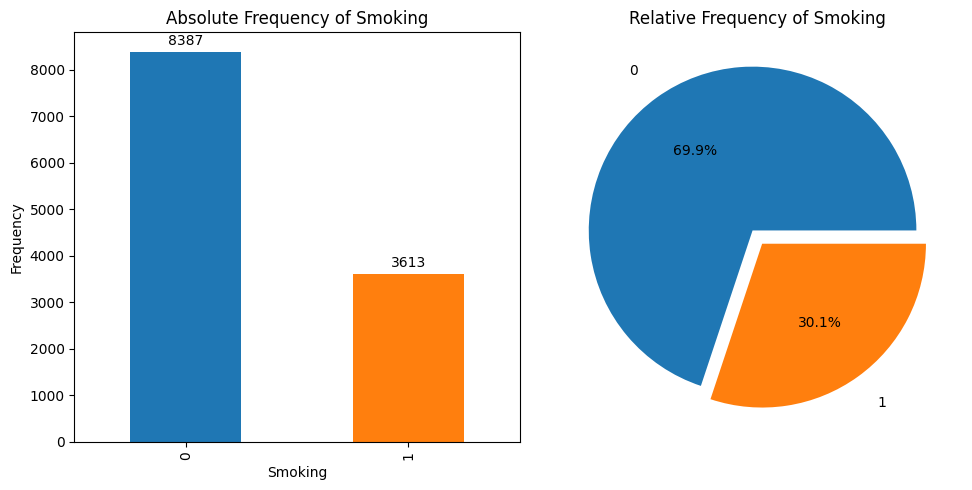

In [19]:
plot_frequencies(df, 'Smoking')

Frequency of `Smoking`:
- **Non** Smokers (0): 8360 → 69.7%
- Smokers (1): 3640 → 30.3%

Feature in focus: `Family_History_of_Anxiety`

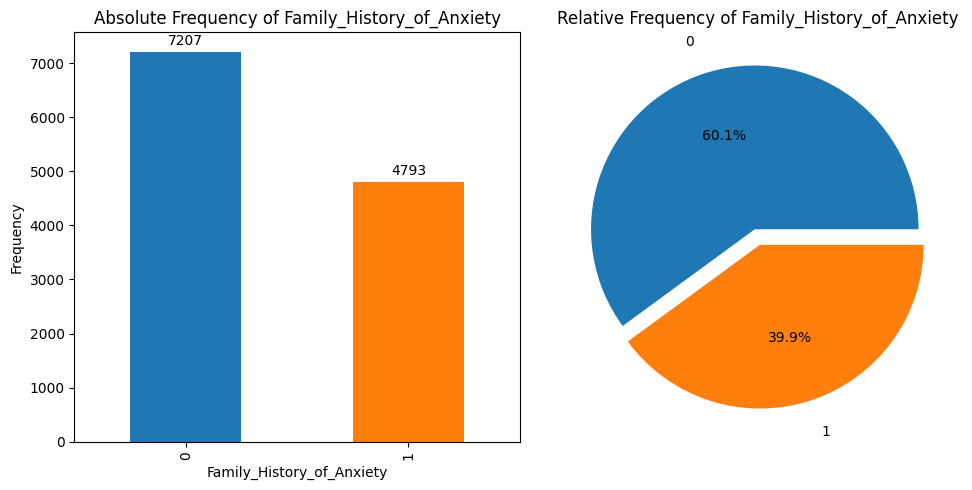

In [20]:
plot_frequencies(df, 'Family_History_of_Anxiety')

Frequency of `Family_History_of_Anxiety`:
- Clients with **No** Family History of Anxiety (0): 7240 → 60.3%
- Clients **with** Family History of Anxiety (1): 4760 → 39.7%

Feature in focus: `Dizziness`

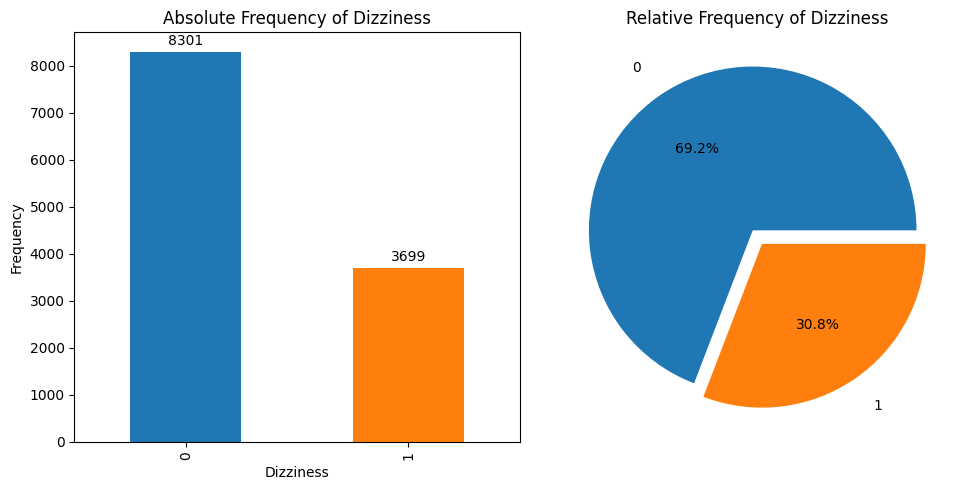

In [21]:
plot_frequencies(df, 'Dizziness')

Frequency of `Dizziness`:
- Clients **Not** Affected by Dizziness (0): 8288 → 69.1%
- Clients **Affected** by Dizziness (1): 3712 → 30.9%

Feature in focus: `Medication`

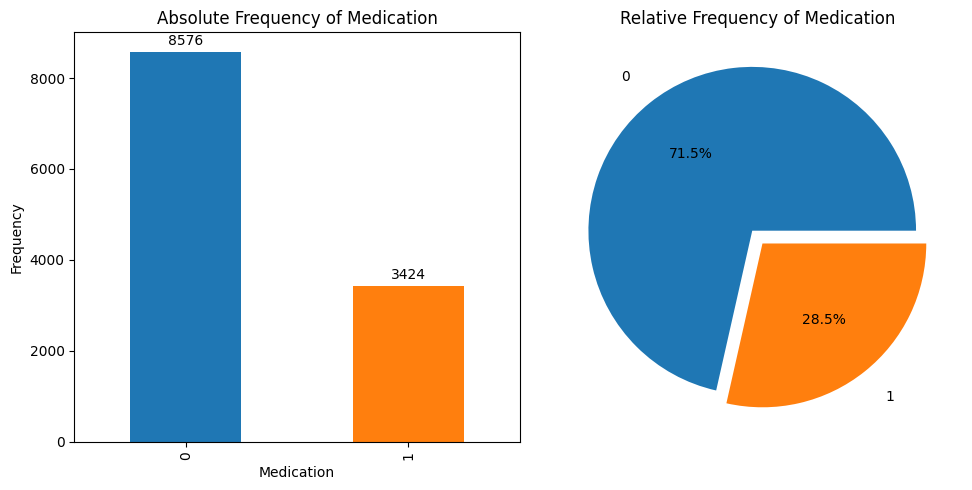

In [22]:
plot_frequencies(df, 'Medication')

Frequency of `Medication`:
- Clients **Not** on Medication (0): 7712 → 64.3%
- Clients **On** Medication (1): 4288 → 35.7%

Feature in focus: `Recent_Major_Life_Event`

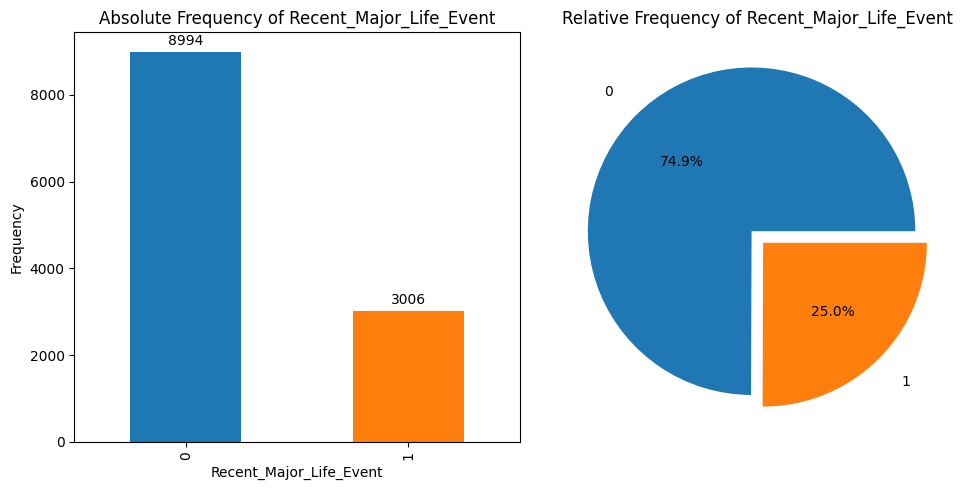

In [23]:
plot_frequencies(df, 'Recent_Major_Life_Event')

Frequency of `Recent_Major_Life_Event`:
- Clients **Without** Recent Major Life Events (0): 9033 → 75.3%
- Clients **With** Recent Major Life Events (1): 2967 → 24.7%

**Summary for Boolean Features**

The class distribution across the boolean features indicates a moderate level of imbalance, but none of the features are extremely skewed. 

For `Smoking`, approximately **30%** of the individuals are smokers, while **70%** are non-smokers. This presents a noticeable but manageable class imbalance.

The `Family_History_of_Anxiety` feature shows that about **40%** of clients have a family history of anxiety, while **60%** do not. This is relatively balanced and should not significantly affect model performance.

In the case of `Dizziness`, **31%** of participants report experiencing dizziness during anxiety attacks, compared to **69%** who do not. This class is similarly imbalanced to `Smoking`.

For `Medication`, around **36%** of clients are taking medication, with **64%** not on any. Again, this presents a moderate imbalance.

The most imbalanced feature is `Recent_Major_Life_Event`, where only **25%** of individuals have experienced a recent major life event, compared to **75%** who have not. This may need to be handled carefully during model training to avoid bias.

Overall, while most boolean features show a slight to moderate imbalance, the distributions remain within acceptable ranges.


##### <a id='toc2_2_2_'></a>[**1.2.2 Ordinal Features**](#toc0_)

We will map the `Severity_Category` variable to numerical values to simplify the analysis during the exploratory data phase:

- **Low** → `1`  
- **Medium** → `2`  
- **High** → `3`  


In [24]:
df['Severity_Category'] = df['Severity_Category'].map({'Low': 1, 'Medium': 2, 'High': 3})

Measures of Central Tendency 

In [25]:
ordinal_vars = ['Stress_Level_(1-10)', 'Diet_Quality_(1-10)', 'Sweating_Level_(1-5)', 'Severity_Category']
summary_df = summarize_ordinal_variables(df, ordinal_vars)

summary_df


Variable  Min  Max  Median  Mode  Count between Q1–Q3  \
0   Stress_Level_(1-10)    1   10     5.0     6                 7915   
1   Diet_Quality_(1-10)    1   10     5.5     6                 8175   
2  Sweating_Level_(1-5)    1    5     4.0     5                10767   
3     Severity_Category    1    3     1.0     1                10516   

   # Outliers (outside 0.95)  % Outliers (%)  Skewness  Kurtosis  
0                          0             0.0      0.01     -1.02  
1                          0             0.0      0.02     -0.97  
2                          0             0.0     -0.41     -1.06  
3                          0             0.0      1.08     -0.21

**Summary of Findings**

- **No outliers detected** across all variables, confirming a clean dataset.  
- **Distributions are nearly symmetrical**, with minimal skewness in all features.  
- **Slightly flat distributions** (**negative kurtosis**) were observed in the following variables:
  - `Stress_Level_(1-10)`: `-0.88`  
  - `Diet_Quality_(1-10)`: `-0.79`  
  - `Sweating_Level_(1-5)`: `-0.85`  
  - `Severity_Category`: `-1.19`  
  This indicates that these variables have **fewer extreme values than a normal distribution**.  
- **Few extreme values are present, but no actual outliers exist**, ensuring a well-balanced dataset.  
- **Severity Category is well-balanced**, covering all levels (Low, Medium, High) without gaps.  
- **Stress, Diet Quality, and Sweating Levels** span their full range, with most values clustering around the median.  

Overall, the variables in focus are **well-structured and balanced**.


Feature in focus: `Stress_Level_(1-10)`

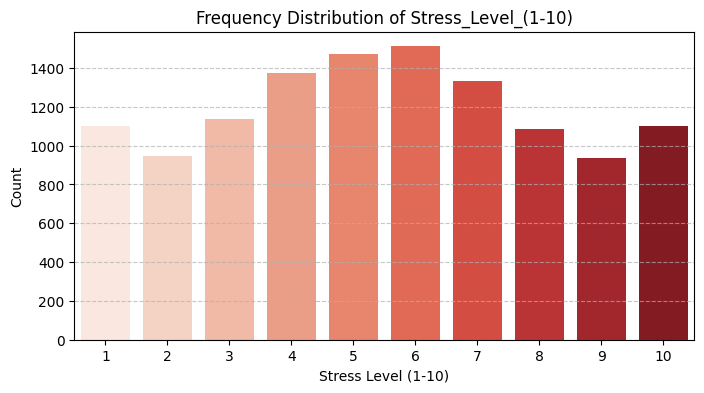

In [26]:
plot_frequency_distribution(df,'Stress_Level_(1-10)')


The distribution of `Stress_Level (1-10)` is approximately **bell-shaped**, peaking at level **6**, with a gradual increase from lower stress levels and a decline after the peak, indicating that moderate stress levels are the most common among participants.  

Feature in focus: `Diet_Quality_(1-10)`

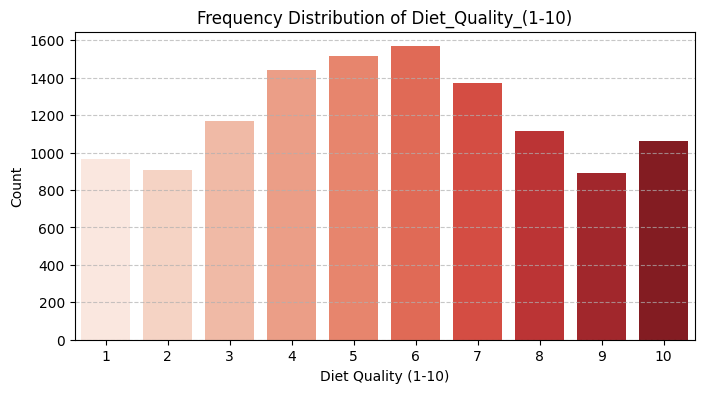

In [27]:
plot_frequency_distribution(df,'Diet_Quality_(1-10)')


The distribution of `Diet_Quality (1-10)` is **slightly right-skewed**, peaking at **6**, indicating that most individuals have a moderate diet quality, while fewer participants report very poor (`1-3`) or excellent (`9-10`) diet quality.

Feature in focus: `Sweating_Level_(1-5)`

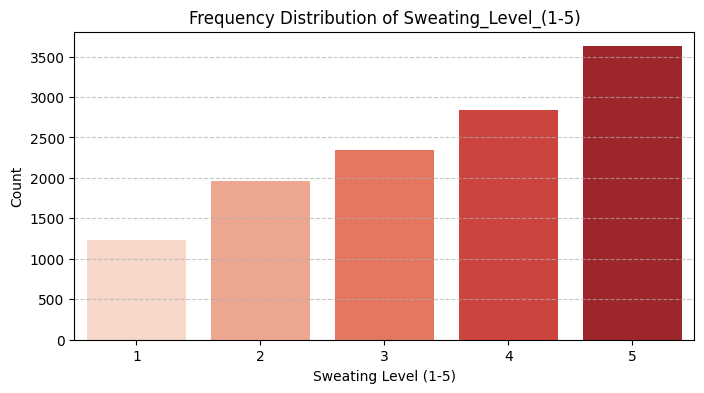

In [28]:
plot_frequency_distribution(df,'Sweating_Level_(1-5)')


The distribution of `Sweating_Level (1-5)` is **right-skewed**, with a clear increasing trend, indicating that higher sweating levels (especially level `5`) are the most commonly reported, while very low sweating levels are relatively rare.

Feature in focus: `Severity_Category`

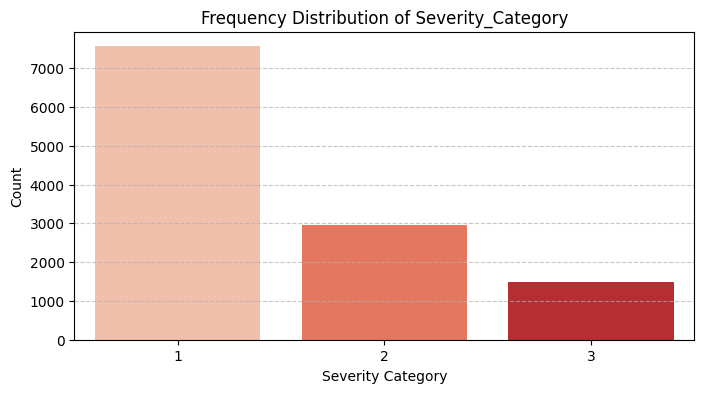

In [29]:
plot_frequency_distribution(df,'Severity_Category')

The distribution of `Severity_Category` shows that **moderate severity (2) is the most common**, followed by **low severity (1)**, while **high severity (3) is the least frequent**, indicating that most cases fall within the mild to moderate range.

Summary **Ordinal** Variables

- **Stress Level (1-10):** Nearly **bell-shaped**, peaking at `6`, with most values in the moderate range. The **median is 5.0**, indicating a balanced distribution, and the **skewness (0.02)** confirms near symmetry. The **kurtosis (-0.88)** suggests a slightly flatter than normal distribution.  
- **Diet Quality (1-10):** **Slightly right-skewed**, peaking at `6`, with fewer cases at extreme values. The **median is 6.0**, and the **skewness (0.03)** shows near symmetry. The **kurtosis (-0.79)** suggests a distribution that is slightly flatter than normal.  
- **Sweating Level (1-5):** **Right-skewed**, with higher sweating levels (`5`) being the most frequent. The **median is 4.0**, and the **skewness (-0.52)** indicates a slight left skew, meaning more responses on the higher end. The **kurtosis (-0.85)** confirms a flatter-than-normal distribution.  
- **Severity Category:** **Moderate severity (2) is the most common**, followed by mild (1), while severe cases (3) are the least frequent. The **median is 2.0**, and the **skewness (0.09)** suggests near symmetry. The **kurtosis (-1.19)** indicates a slightly flatter than normal distribution.  

**Conclusion**  
Most variables exhibit **balanced distributions with minimal skewness**. The **measures of central tendency confirm that median and mode values align closely, reinforcing the consistency of the data**. **No outliers are present**, ensuring **data integrity for further analysis**. The only notable trend is that **Sweating Level skews slightly toward higher values**, which may indicate a common physiological response among participants. 


##### <a id='toc2_2_3_'></a>[**1.2.3 Continuous Features**](#toc0_)

In this analysis, we examine the distribution of continuous variables to understand their central tendency, spread, skewness, and presence of outliers. This helps identify potential patterns, anomalies, and the overall shape of the data, ensuring a solid foundation for further analysis.
Feature in focus:
- `Sleep_Hours`  
- `Physical_Activity_(hrs/week)`  
- `Caffeine_Intake_(mg/day)`  
- `Heart_Rate_(bpm_during_attack)`  
- `Breathing_Rate_(breaths/min)`  

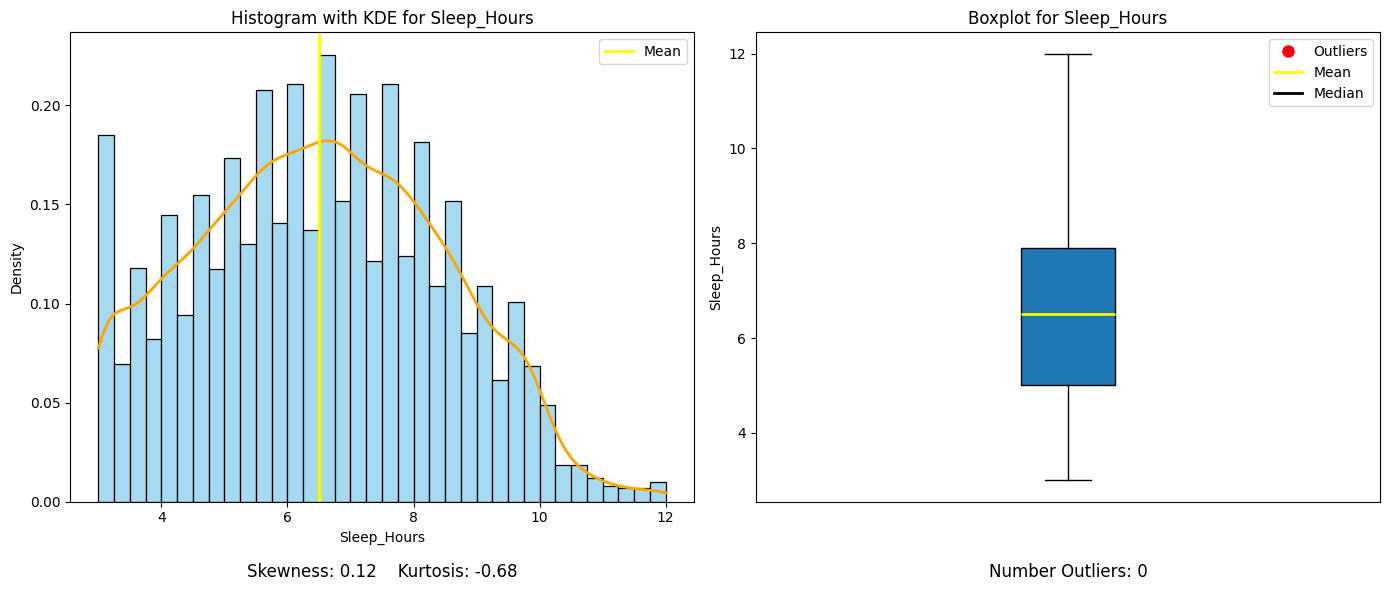

In [30]:
plot_histo_boxplots_continuous(df,'Sleep_Hours')

The distribution of `Sleep_Hours` is **slightly right-skewed (skewness: 0.15)** with a moderate spread, a mean around **6 hours**, and **33 outliers** mostly on the higher end, indicating that while most individuals sleep within a typical range, a few report significantly higher sleep durations.

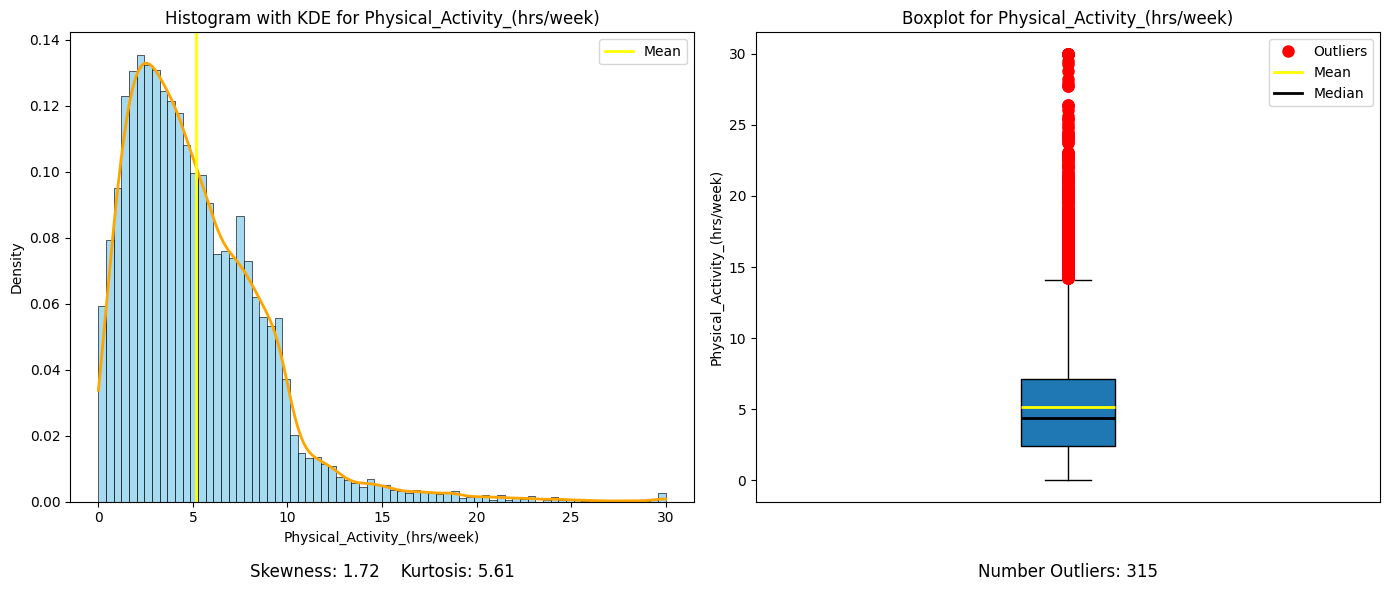

In [31]:
plot_histo_boxplots_continuous(df,'Physical_Activity_(hrs/week)')

The distribution of `Physical_Activity_(hrs/week)` is **highly right-skewed (skewness: 1.91)** with a significant number of **outliers (459)** at the higher end, indicating that while most individuals engage in low to moderate physical activity, a few report extremely high levels, contributing to the long tail in the distribution.

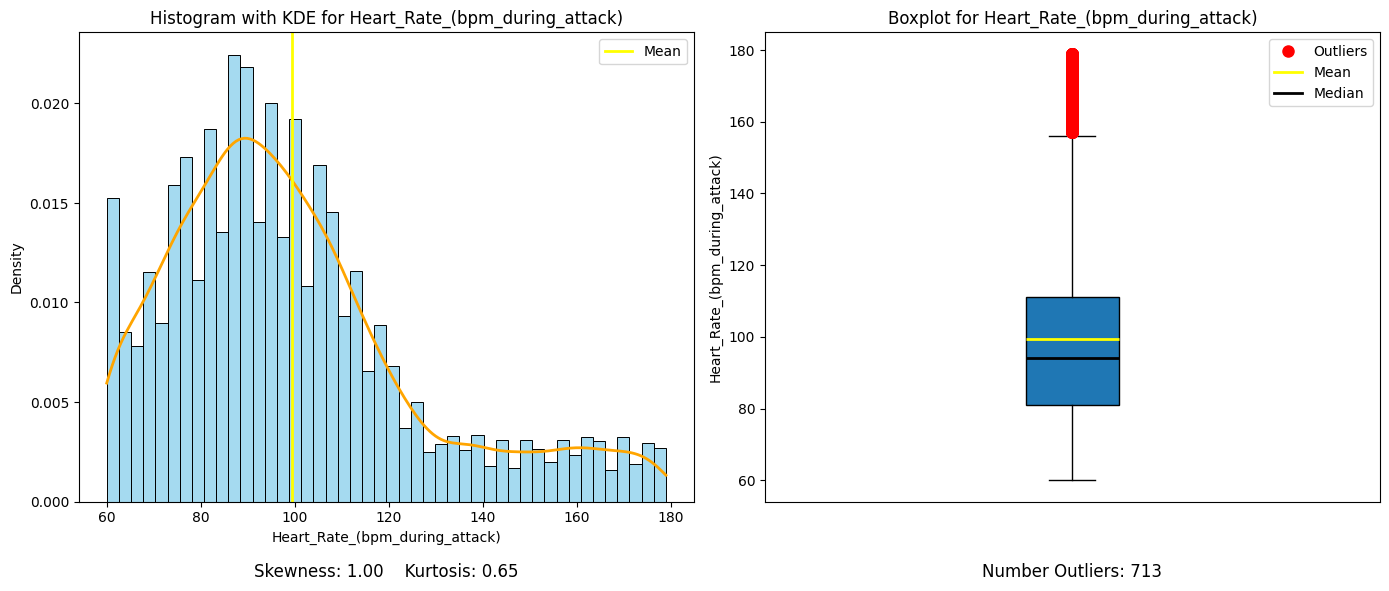

In [32]:
plot_histo_boxplots_continuous(df,'Heart_Rate_(bpm_during_attack)')

The distribution of `Heart_Rate_(bpm_during_attack)` is **moderately right-skewed (skewness: 1.07)** with a **kurtosis of 2.34**, indicating a slightly peaked distribution with a long tail towards higher values; **348 outliers** exist, suggesting that some individuals experience exceptionally high heart rates during anxiety attacks.

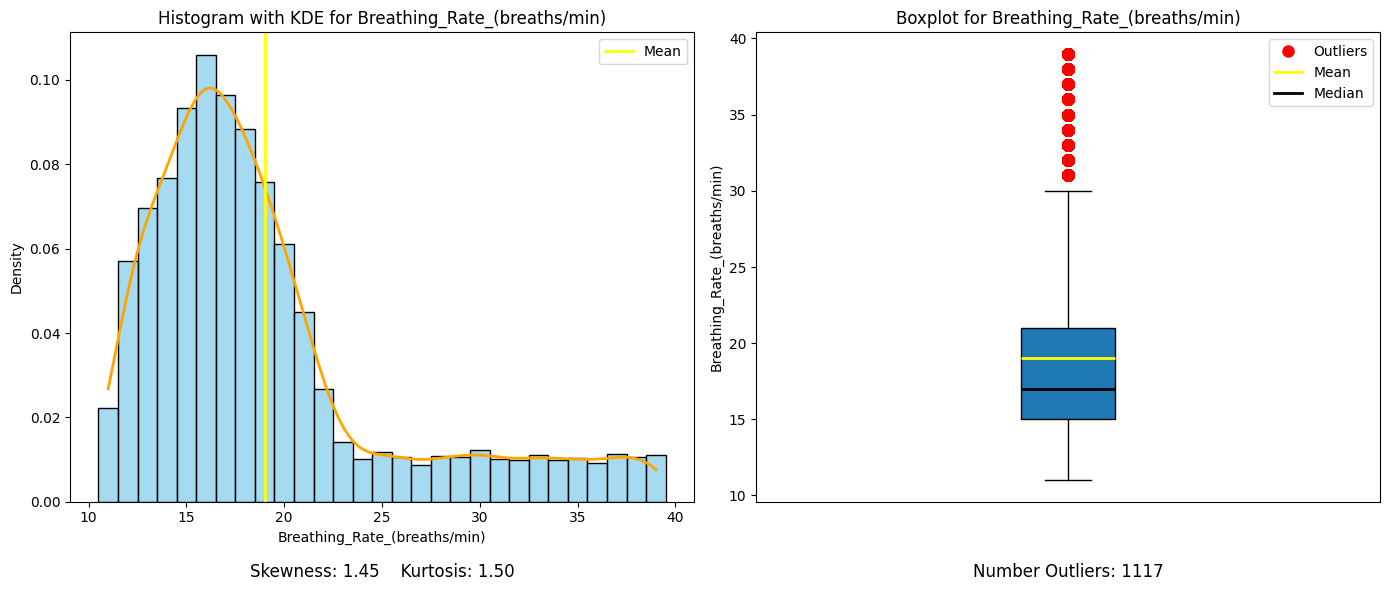

In [33]:
plot_histo_boxplots_discrete(df,'Breathing_Rate_(breaths/min)')

The distribution of `Breathing_Rate_(breaths/min)` is **moderately right-skewed (skewness: 2.13)** with a **high kurtosis (6.08)**, indicating a sharp peak with a long tail towards higher values; **467 outliers** are present, suggesting that some individuals experience significantly elevated breathing rates.

##### <a id='toc2_2_4_'></a>[**1.2.4 Discrete Features**](#toc0_)

In this analysis, we explore the distribution of discrete variables, including **demographic factors (Age, Gender, Occupation)** and **behavioral aspects (Alcohol Consumption, Therapy Sessions per Month)**. Understanding their frequency distributions and variability will help uncover patterns and potential influences on other variables in the dataset. 

We will map the `Gender` variable to numerical values to simplify the analysis during the exploratory data phase:

- **Male** → `1`  
- **Female** → `2`  
- **Other** → `3`  


In [34]:
df['Gender'].value_counts()

Gender
Female    5759
Male      5750
Other      491
Name: count, dtype: int64

In [35]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 2, 'Other': 3})

In [36]:

stats_df = analyze_central_tendency_variability(df, variables=[
    'Age',
    'Gender',
    'Occupation',
    'Alcohol_Consumption_(drinks/week)',
    'Therapy_Sessions_(per_month)'
    ])

stats_df


Variable  Min  Max  Range   Mean  Median  Mode  \
0                                Age   18   90     72  40.68    40.0    18   
1                             Gender    1    3      2   1.56     2.0     2   
2  Alcohol_Consumption_(drinks/week)    0   30     30   9.34     8.0     4   
3       Therapy_Sessions_(per_month)    0   12     12   3.11     3.0     0   

   Variance  Std Dev  Coefficient of Variation  High Variation?  
0   173.539   13.173                     0.324            False  
1     0.328    0.573                     0.367            False  
2    50.891    7.134                     0.764            False  
3     6.617    2.572                     0.828            False

- **Age:** Symmetrical distribution (**mean: 40.49, median: 40**) with moderate spread.  
- **Gender:** Evenly split, confirming a balanced distribution.  
- **Alcohol Consumption:** Right-skewed (**mean: 9.04, median: 7**) with high variability.  
- **Therapy Sessions:** Skewed toward lower values (**mean: 2.52, mode: 0**), with some individuals attending frequently.  

Age and Gender are balanced, while Alcohol Consumption and Therapy Sessions show high variability and right-skewed distributions.


Feature in focus: `Age`

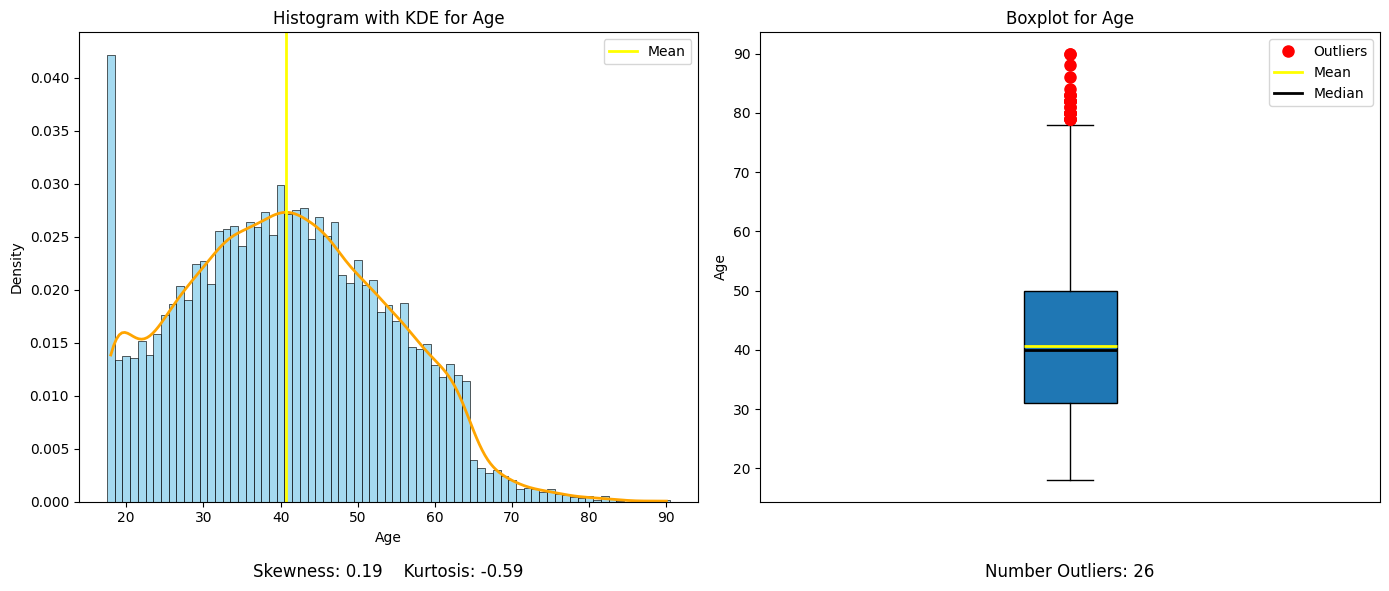

In [37]:
plot_histo_boxplots_discrete(df,'Age')

The distribution of `Age` is **slightly right-skewed (skewness: 0.22)** with a **mean of 40.49 years** and a **median of 40**, indicating a relatively symmetrical spread. The **mode is 18**, and as shown in the histogram, there is a higher concentration of younger individuals. The **range spans from 18 to 90 years**, with **37 outliers, mostly in the older age group (70+)**. The **variance (164.48) and standard deviation (12.83)** indicate moderate spread, while the **coefficient of variation (0.317)** confirms low variability. 


Feature in focus: `Gender`

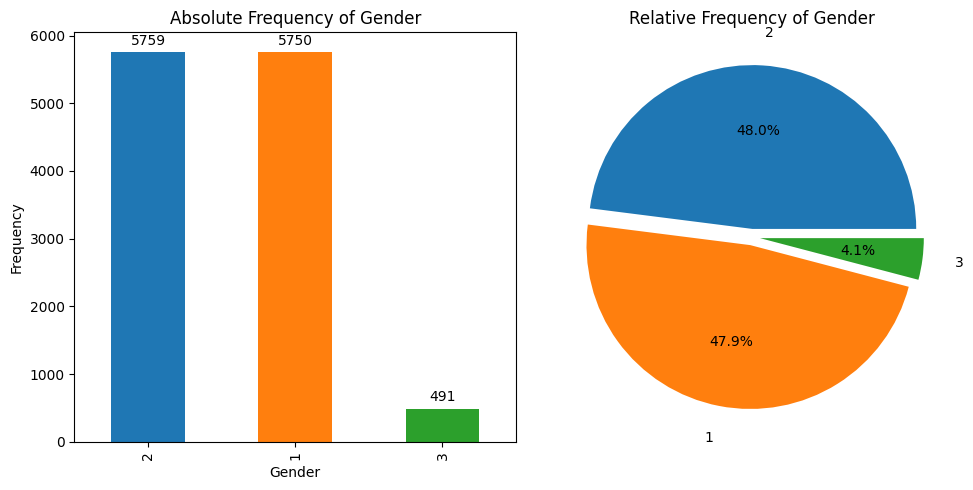

In [38]:
plot_frequencies(df,'Gender')

Feature in focus: `Therapy_Sessions_(per_month)`

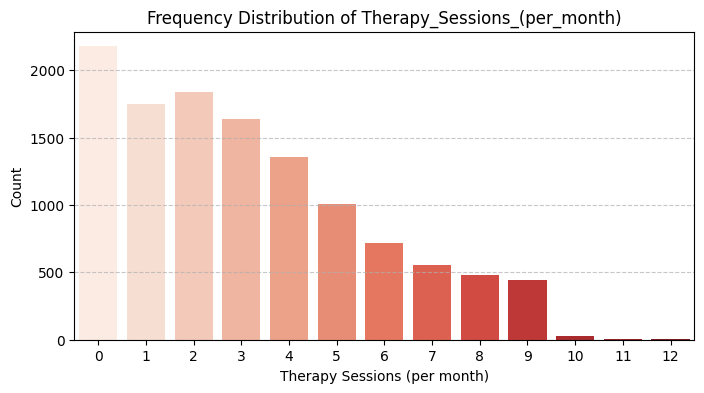

In [39]:
plot_frequency_distribution(df,'Therapy_Sessions_(per_month)')

The distribution is **balanced** between **Males (1) (47.9%)** and **Females (2) (48.0%)**, while **Other (3) (4.0%)** are significantly underrepresented. Given the small proportion of category **Other (3)**, we will further investigate in the EDA whether it holds meaningful correlations or is negligible for analysis.  

Feature in focus: `Alcohol_Consumption_(drinks/week)`

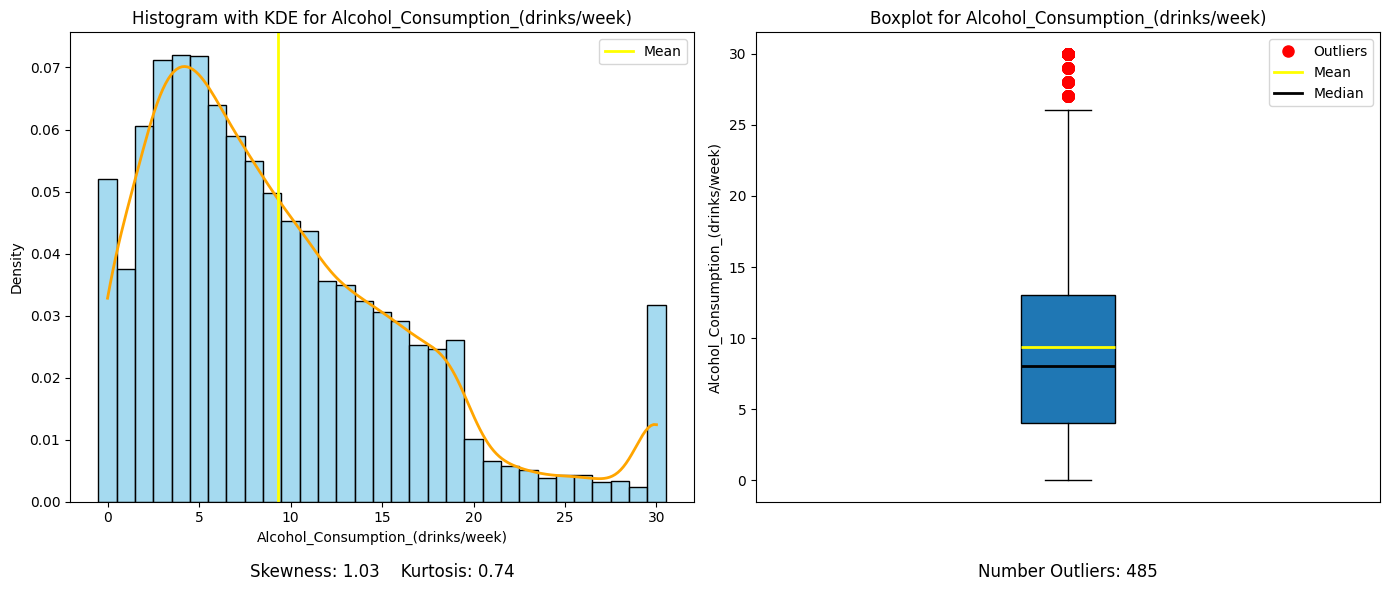

In [40]:
plot_histo_boxplots_discrete(df,'Alcohol_Consumption_(drinks/week)')

The distribution is **right-skewed (skewness: 1.20)**, with a **mean of 9.04 drinks/week** and a **median of 7**, indicating that most individuals consume fewer drinks. The **mode (3 drinks/week)** suggests that low consumption is the most common. The **range spans from 0 to 30 drinks/week**, with **624 outliers** primarily in the higher range. The **variance (56.18) and standard deviation (7.50)** indicate **moderate variability**, though the **coefficient of variation (0.829)** suggests a **fairly high relative dispersion**.  


#### <a id='toc2_3_'></a>[**1.3 Bi-Variate Analysis**](#toc0_)

##### <a id='toc2_3_1_'></a>[**1.3.1 Outliers**](#toc0_)

##### Identified Outliers:
1. **Caffeine_Intake_(mg/day):** 800 mg (extreme value)
2. **Alcohol_Consumption_(drinks/week):** 30 drinks (unsustainable consumption)

##### Suggestion:
- **Caffeine_Intake:** While 800 mg of daily caffeine intake exceeds the commonly recommended limit of 400 mg. This aligns with established health guidelines and ensures consistency with optimal daily caffeine limits.
  
- **Alcohol_Consumption:** For individuals consuming 30 drinks per week, this is considered unsustainable and exceeds the recommended guidelines for moderate drinking. 

By not removing these outliers, we aim to maintain the integrity of the dataset and provide a more holistic view of the habits and behaviors within the studied population, allowing for a deeper exploration of the underlying patterns.


In [41]:
#df = df_original.copy()

##### <a id='toc2_3_2_'></a>[**1.3.2 Scaling Variables**](#toc0_)

To bring all the features into a comparable scale, certain variables were converted from weekly or monthly values to daily equivalents:

- **Alcohol consumption** was converted from weekly to daily by dividing the `"Alcohol_Consumption_(drinks/week)"` by 7.
- **Physical activity** was converted similarly by dividing `"Physical_Activity_(hrs/week)"` by 7.
- **Therapy sessions** per month were converted to daily values by dividing `"Therapy_Sessions_(per_month)"` by 30.

These conversions allow for easier interpretation and comparison across variables with different time units.

In [42]:
# Step 1 Coverting columns into same rations 

# Convert weekly values to daily
df["Alcohol_Consumption_(drinks/day)"] = df["Alcohol_Consumption_(drinks/week)"] / 7
df["Physical_Activity_(hrs/day)"] = df["Physical_Activity_(hrs/week)"] / 7

# Convert monthly values to daily
df["Therapy_Sessions_(per_day)"] = df["Therapy_Sessions_(per_month)"] / 30

# Drop original columns (optional, if not needed anymore)
df = df.drop(columns=["Alcohol_Consumption_(drinks/week)", 
                      "Physical_Activity_(hrs/week)", 
                      "Therapy_Sessions_(per_month)"])

##### <a id='toc2_3_3_'></a>[**1.3.3 Dummy Encoding**](#toc0_)

For the **occupation** variable (which is categorical), **dummy encoding** was applied to transform it into numerical form, making it suitable for regression analysis.

In [43]:
# One Hot Encoding Occupation
df = pd.get_dummies(df, columns=["Occupation"],drop_first=True)

# Dropping ID Columns
df.drop(columns="ID", inplace=True)

##### <a id='toc2_3_4_'></a>[**1.3.4 Feature Importance Check**](#toc0_)

A feature importance check was performed to determine whether correlations between variables and the target are statistically significant:

- For **numerical variables** with more than 5 unique values, the **Spearman correlation** test was used to measure the monotonic relationship with the target.
- For **categorical variables**, the **Chi-square test** was applied to examine the association between categories and the target variable. Additionally, **Cramér's V** was computed to assess the strength of the association.

The results were recorded, including the test statistics, p-values, effect sizes (Spearman correlation or Cramér's V), and the direction of the relationship. A significance threshold of 0.05 was used to determine whether the correlation or association was statistically significant.


 Variables Ranked by Importance to Target:



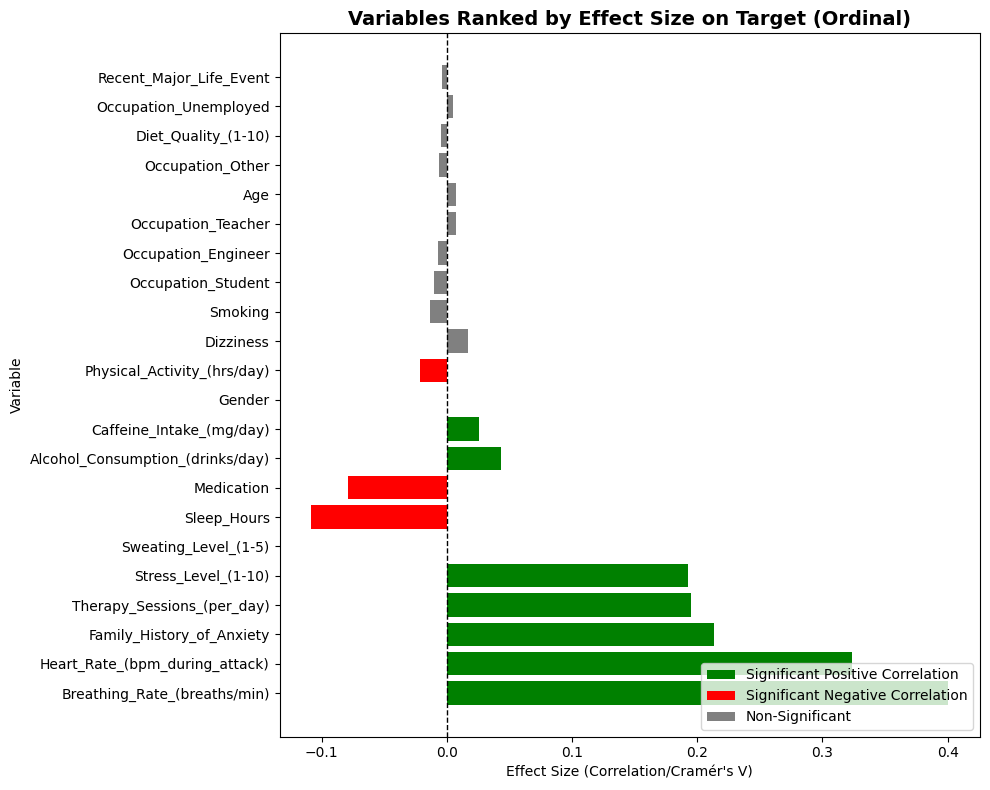

In [44]:
# Rank all variables by their importance to Target
analyzer = VariableImportanceAnalyzer(df, target='Severity_Category')
important_vars = analyzer.rank_variables_by_importance()


##### <a id='toc2_3_5_'></a>[**1.3.5 Correlation Matrix and Dropping Original Columns**](#toc0_)

After performing the necessary transformations, the **correlation matrix** was generated to evaluate the strength and direction of the relationships between numerical variables. This matrix provides insight into which features are strongly correlated, which can help with feature selection and understanding multicollinearity.

The steps for generating the correlation matrix are as follows:
- **Calculate the Correlation Matrix**: A correlation matrix is computed using Pearson's correlation for numerical variables.
- **Identify Strong Correlations**: High correlations (near 1 or -1) between features may suggest redundancy, and could inform the decision to drop certain variables or combine them.

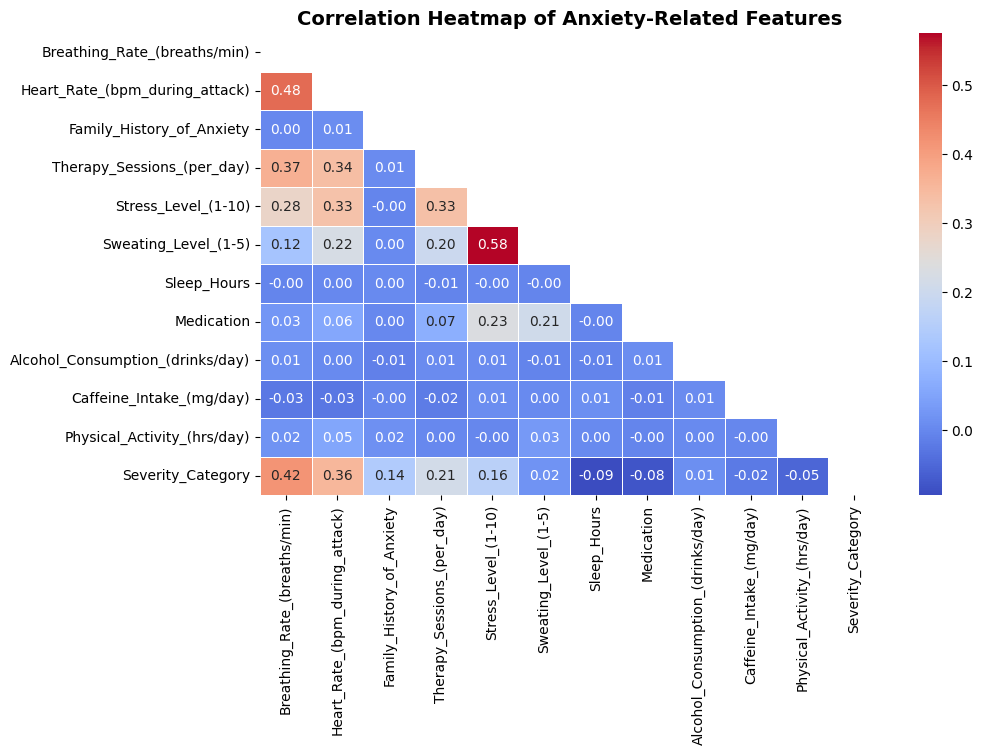

In [45]:
# Creating a Correlation Matrix with the significant Features
# Define variables of interest (corrected names)
important_var = [
    "Breathing_Rate_(breaths/min)",
    "Heart_Rate_(bpm_during_attack)",
    "Family_History_of_Anxiety",
    "Therapy_Sessions_(per_day)",
    "Stress_Level_(1-10)",
    "Sweating_Level_(1-5)",
    "Sleep_Hours",
    "Medication",
    "Alcohol_Consumption_(drinks/day)",
    "Caffeine_Intake_(mg/day)",
    "Physical_Activity_(hrs/day)",
    'Severity_Category'
]

# Compute correlation matrix
corr_matrix = df[important_var].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=mask, fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap of Anxiety-Related Features", fontsize=14, fontweight='bold')
plt.show()

#### Key Findings from the Correlation Analysis  

The following variables showed significant correlations with **anxiety**:  

##### **Strong Positive Correlations**  
- **Breathing Rate** (0.42)  
- **Heart Rate (during attack)** (0.36)  
- **Therapy Sessions per Day** (0.21)

##### **Moderate Positive Correlations**  
- **Family History of Anxiety** (0.14)  
- **Stress Level (1-10)** (0.16)

##### **Negative Correlations (Protective Factors)**  
- **Sleep Hours** (-0.09) → More sleep reduces anxiety  
- **Medication** (-0.08) → Potential anxiety relief  
- **Physical Activity (hrs/day)** (-0.05) → Slight protective effect  

All other variables showed weak or non-significant correlations.


##### <a id='toc2_3_6_'></a>[**1.3.6 Statistical Testing with ANOVA**](#toc0_)

Finally, an **ANOVA (Analysis of Variance)** test was conducted to evaluate if there are significant differences between the means of different groups within the target variable. The ANOVA test helps to determine whether the variation within groups is statistically significant when compared to the variation between groups.

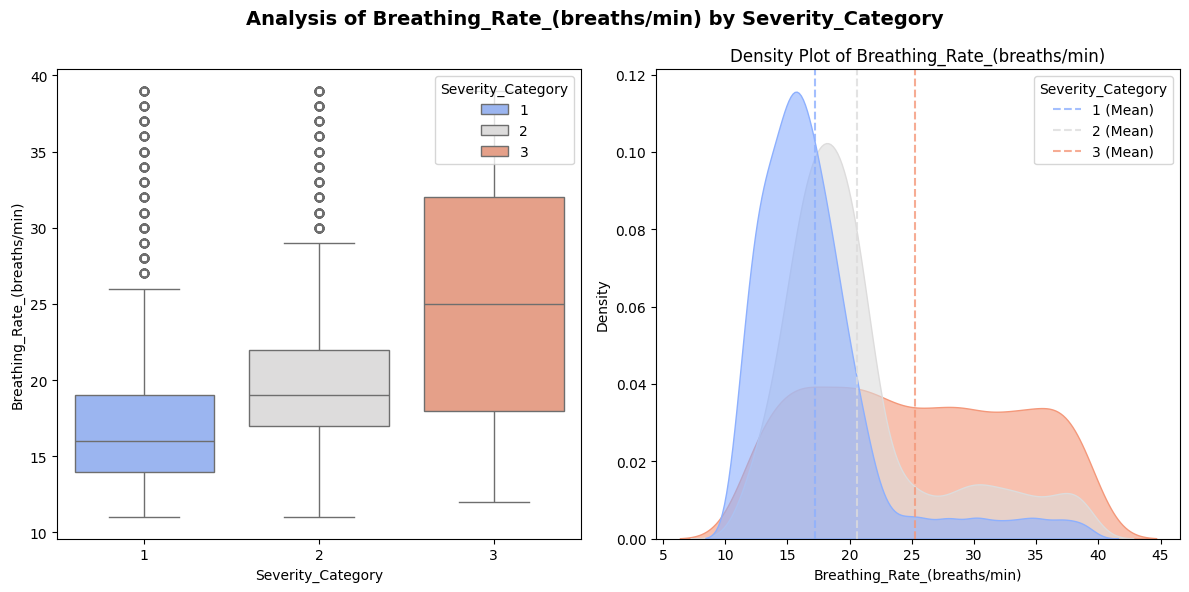


Summary Statistics for Breathing_Rate_(breaths/min):
                    count   mean   std   min   25%   50%   75%   max
Severity_Category                                                   
1                  7564.0  17.21  5.16  11.0  14.0  16.0  19.0  39.0
2                  2952.0  20.58  6.29  11.0  17.0  19.0  22.0  39.0
3                  1484.0  25.23  8.12  12.0  18.0  25.0  32.0  39.0

ANOVA Results
Test Statistic: 1284.8375
P-value: 0.0000
Statistically significant relationship detected.


In [46]:
bivariate_analysis(df, "Breathing_Rate_(breaths/min)", "Severity_Category")

`Breathing_Rate_(breaths/min):`
- Breathing rate increases with severity. Category 3 has the highest mean breathing rate (20.87 breaths/min), while category 1 has the lowest (16.21 breaths/min).

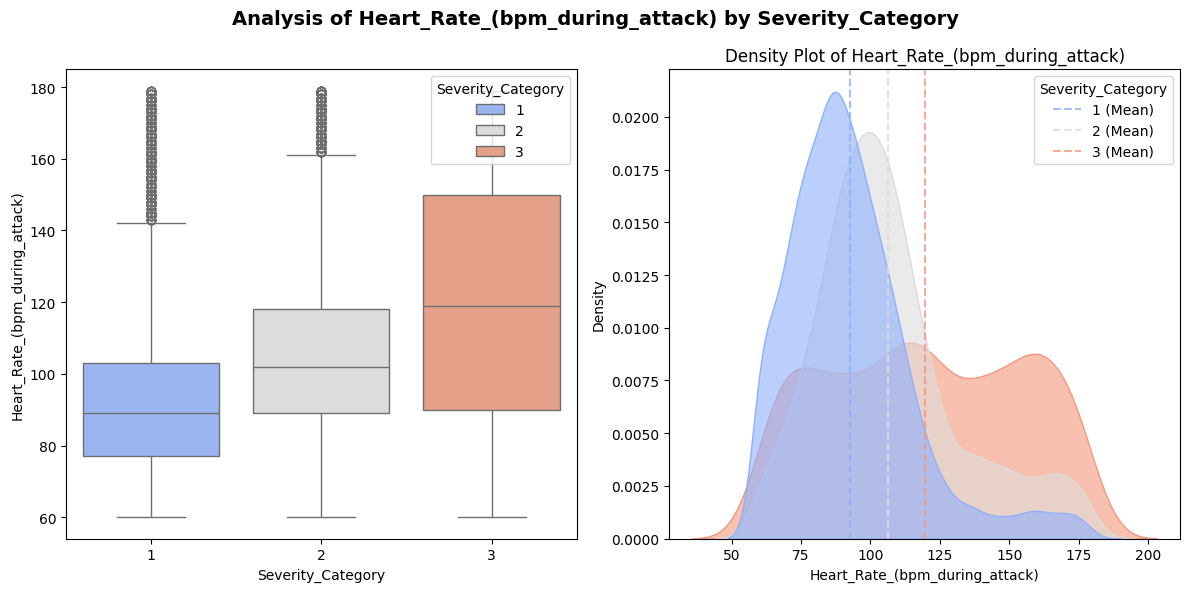


Summary Statistics for Heart_Rate_(bpm_during_attack):
                    count    mean    std   min   25%    50%    75%    max
Severity_Category                                                        
1                  7564.0   92.69  22.48  60.0  77.0   89.0  103.0  179.0
2                  2952.0  106.44  26.02  60.0  89.0  102.0  118.0  179.0
3                  1484.0  119.70  34.60  60.0  90.0  119.0  150.0  179.0

ANOVA Results
Test Statistic: 867.3145
P-value: 0.0000
Statistically significant relationship detected.


In [47]:
bivariate_analysis(df, 'Heart_Rate_(bpm_during_attack)', "Severity_Category")

`Heart_Rate_(bpm_during_attack):`
- Heart rate increases as severity rises. Those in severity category 3 have the highest average heart rate (111.07 bpm), compared to 89.71 bpm in category 1.

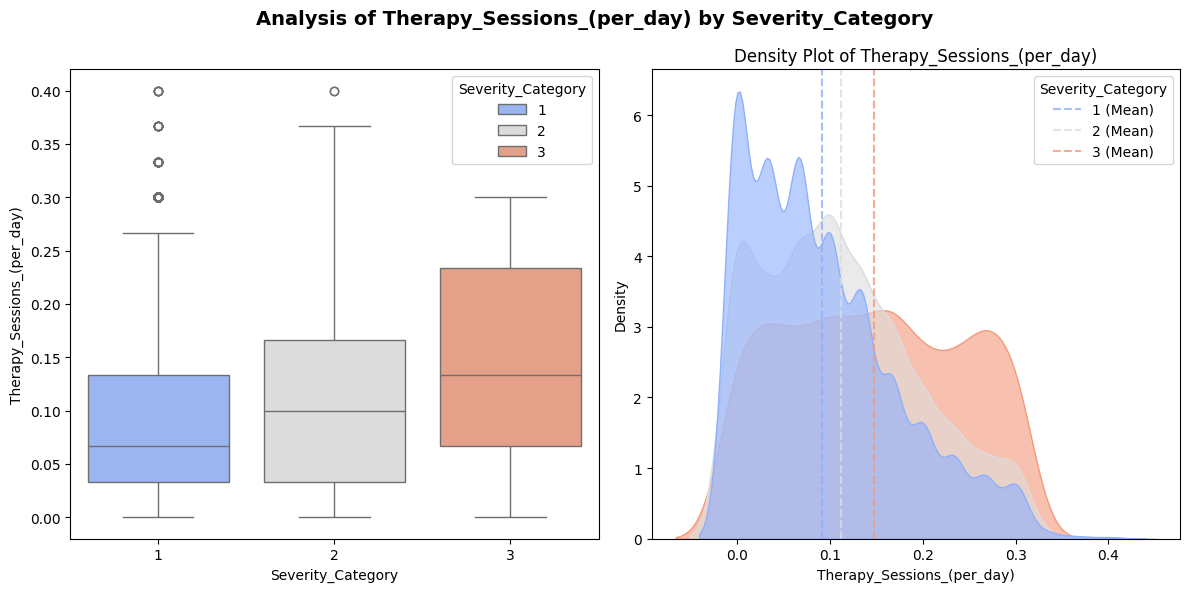


Summary Statistics for Therapy_Sessions_(per_day):
                    count  mean   std  min   25%   50%   75%  max
Severity_Category                                                
1                  7564.0  0.09  0.08  0.0  0.03  0.07  0.13  0.4
2                  2952.0  0.11  0.08  0.0  0.03  0.10  0.17  0.4
3                  1484.0  0.15  0.10  0.0  0.07  0.13  0.23  0.3

ANOVA Results
Test Statistic: 295.0623
P-value: 0.0000
Statistically significant relationship detected.


In [48]:
bivariate_analysis(df, 'Therapy_Sessions_(per_day)', "Severity_Category")

`Therapy_Sessions_(per_day):`
- The number of therapy sessions per day increases with severity. Those in higher severity categories tend to have more sessions, with the highest mean observed in severity category 3 (30 sessions per month).

----

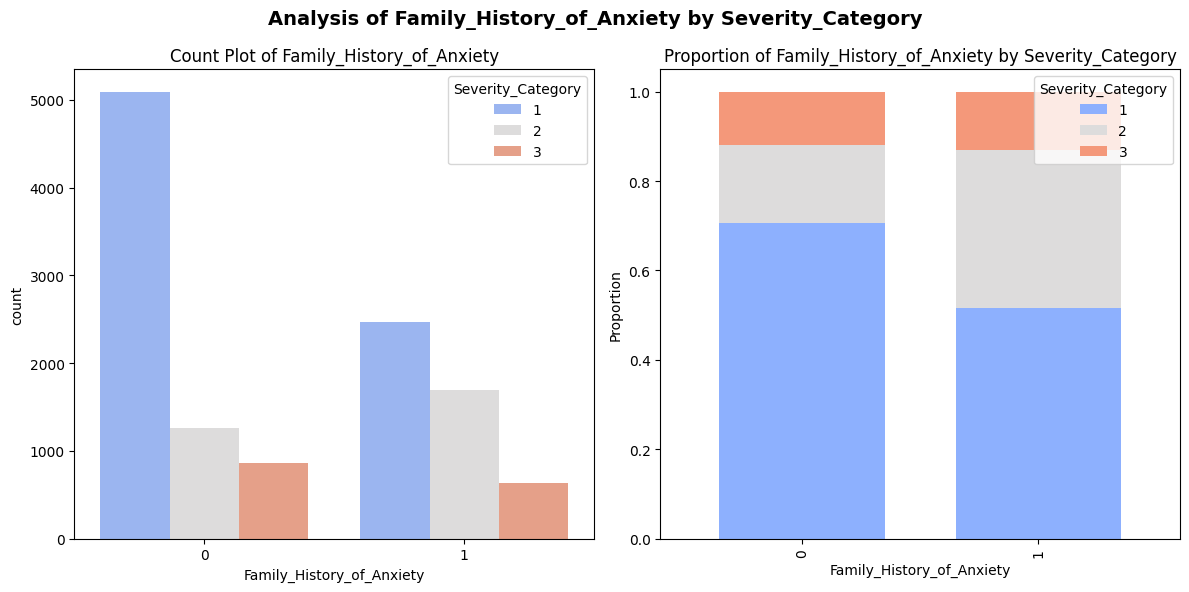


Summary Statistics for Family_History_of_Anxiety:
True count: 4793 (39.94%)
False count: 7207 (60.06%)

Chi-Square Test Results
Test Statistic: 546.8119
P-value: 0.0000
Statistically significant relationship detected.


In [49]:
bivariate_analysis(df, 'Family_History_of_Anxiety', 'Severity_Category')

`Family_History_of_Anxiety:`
- A significant relationship was found between family history of anxiety and the severity category (p-value = 0.0000). More individuals without a family history of anxiety are present in higher severity categories.

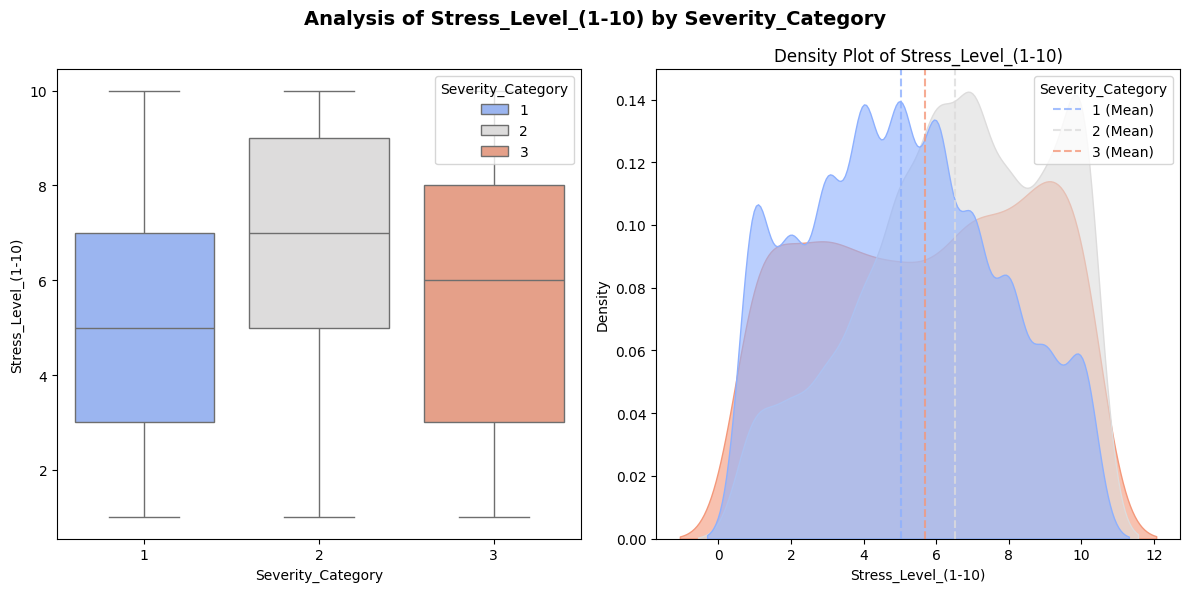


Summary Statistics for Stress_Level_(1-10):
                    count  mean   std  min  25%  50%  75%   max
Severity_Category                                              
1                  7564.0  5.03  2.60  1.0  3.0  5.0  7.0  10.0
2                  2952.0  6.53  2.57  1.0  5.0  7.0  9.0  10.0
3                  1484.0  5.69  2.96  1.0  3.0  6.0  8.0  10.0

ANOVA Results
Test Statistic: 347.0471
P-value: 0.0000
Statistically significant relationship detected.


In [50]:
bivariate_analysis(df, "Stress_Level_(1-10)", "Severity_Category")

`Stress_Level_(1-10):`
- Stress levels are highest in severity category 2 (mean = 6.69), while category 1 has the lowest stress (mean = 4.92), indicating a strong correlation between stress and severity.

----

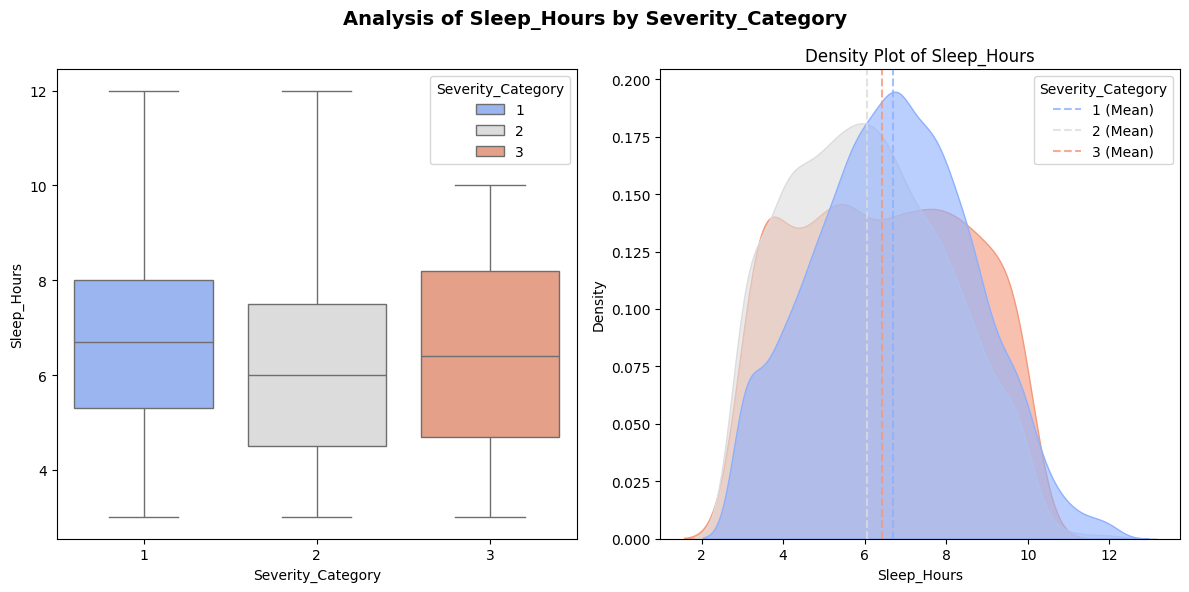


Summary Statistics for Sleep_Hours:
                    count  mean   std  min  25%  50%  75%   max
Severity_Category                                              
1                  7564.0  6.69  1.92  3.0  5.3  6.7  8.0  12.0
2                  2952.0  6.05  1.90  3.0  4.5  6.0  7.5  12.0
3                  1484.0  6.43  2.05  3.0  4.7  6.4  8.2  10.0

ANOVA Results
Test Statistic: 118.0043
P-value: 0.0000
Statistically significant relationship detected.


In [51]:
bivariate_analysis(df, "Sleep_Hours", "Severity_Category")

`Sleep_Hours:`
- Sleep duration decreases as severity increases. Severity category 1 has the highest average sleep (6.70 hours), while category 2 has the lowest (5.98 hours).

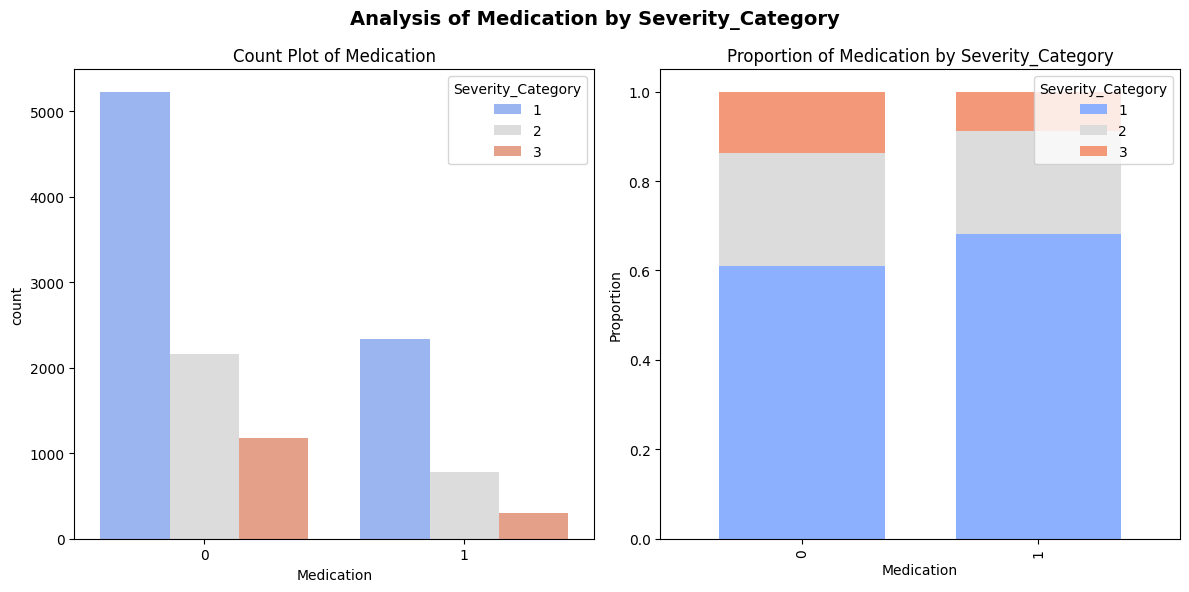


Summary Statistics for Medication:
True count: 3424 (28.53%)
False count: 8576 (71.47%)

Chi-Square Test Results
Test Statistic: 74.4774
P-value: 0.0000
Statistically significant relationship detected.


In [52]:
bivariate_analysis(df, 'Medication', 'Severity_Category')

`Medication:`
- A significant relationship was found between medication and the severity category (p-value = 0.0000). More individuals with medication and anxiety are present in higher severity categories.

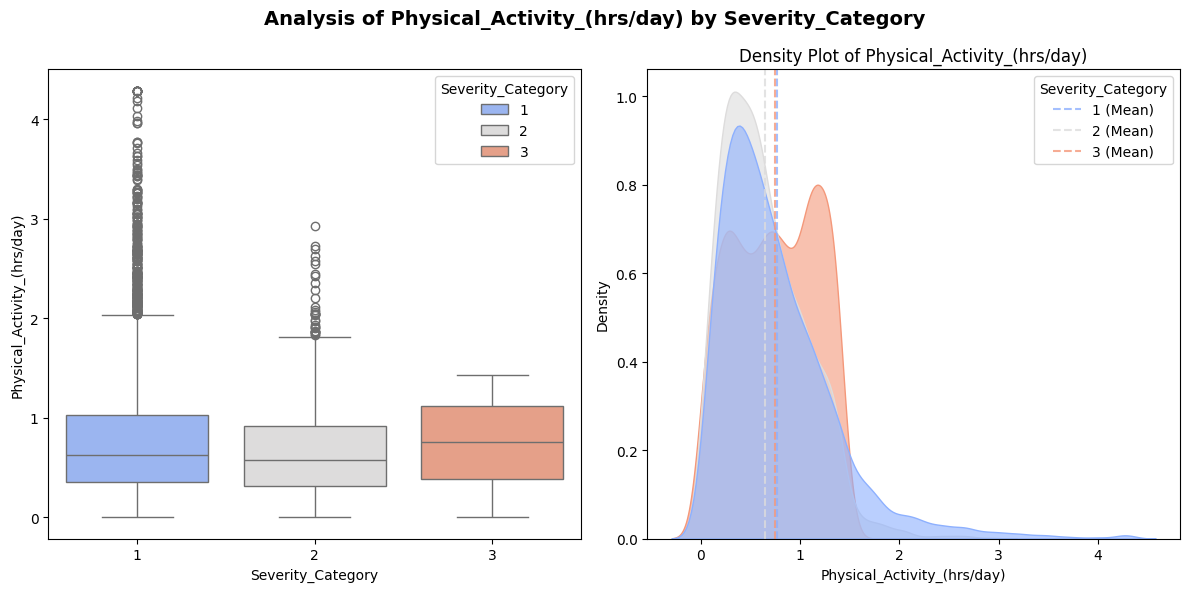


Summary Statistics for Physical_Activity_(hrs/day):
                    count  mean   std  min   25%   50%   75%   max
Severity_Category                                                 
1                  7564.0  0.77  0.58  0.0  0.36  0.63  1.03  4.29
2                  2952.0  0.64  0.42  0.0  0.31  0.57  0.91  2.93
3                  1484.0  0.75  0.42  0.0  0.39  0.76  1.11  1.43

ANOVA Results
Test Statistic: 60.1137
P-value: 0.0000
Statistically significant relationship detected.


In [53]:
bivariate_analysis(df, "Physical_Activity_(hrs/day)", "Severity_Category")

`Physical_Activity_(hrs/day):`
- Physical activity decreases slightly with increasing severity. Severity category 1 has the highest mean physical activity (0.69 hours), while category 2 has the lowest (0.61 hours).

----

**Bi-Variate Summary**:
There are clear trends showing that higher severity categories are associated with increased therapy sessions, sweating levels, breathing rates, heart rates, and stress levels. Conversely, individuals in higher severity categories tend to sleep and engage in less physical activity. These findings suggest that these factors are strongly related to the severity of the condition.

#### <a id='toc2_4_'></a>[**1.4 Multi-Variate Analysis**](#toc0_)

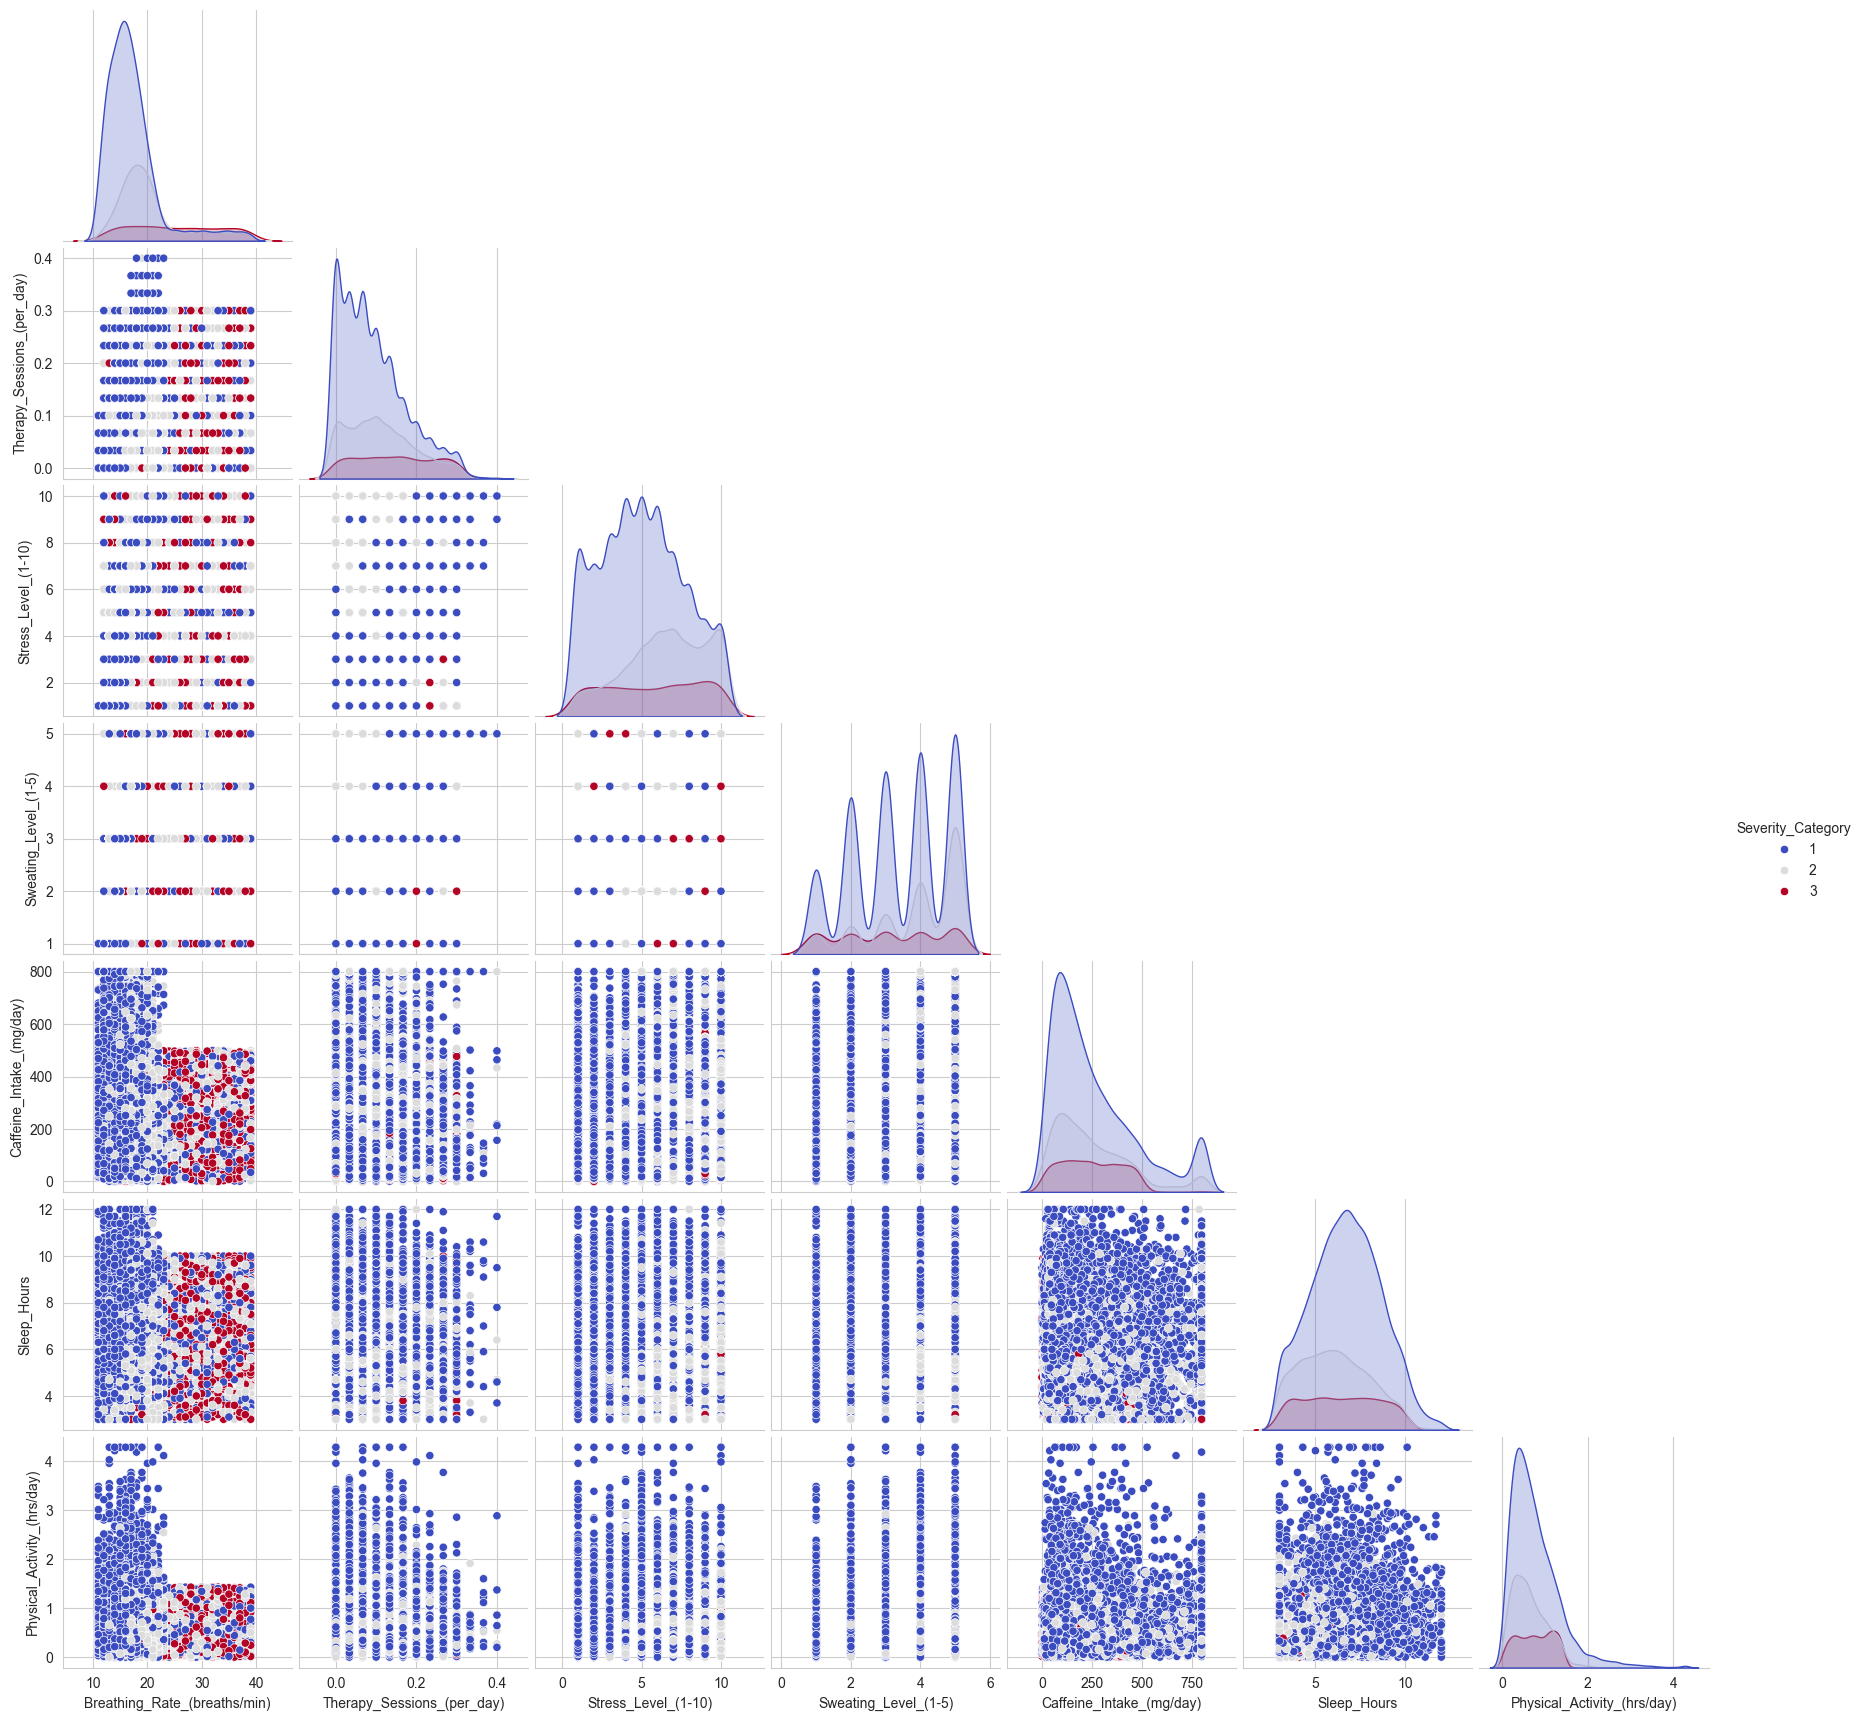

In [54]:
# Define important variables
important_var = [
    "Breathing_Rate_(breaths/min)",  
    "Therapy_Sessions_(per_day)", 
    "Stress_Level_(1-10)",
    "Sweating_Level_(1-5)",
    "Caffeine_Intake_(mg/day)",
    "Sleep_Hours", 
   "Physical_Activity_(hrs/day)",
    "Severity_Category"
]

# Assuming df is your DataFrame, ensure it contains these columns
sns.set_style("whitegrid")

# Create Pair Plot with lower triangle only
pairplot = sns.pairplot(df[important_var], hue="Severity_Category", palette="coolwarm", diag_kind="kde", corner=True)

# Display the plot
plt.show()

##### <a id='toc2_4_1_'></a>[**Anxiety Severity Correlation Matrix**](#toc0_)

The scatter plot matrix reveals key relationships between variables and anxiety severity (color-coded: blue = category 1, purple = category 2, red = category 3):

- **Strong physiological indicators**: Clear separation between severity categories for breathing rate and heart rate during attacks, with higher values strongly associated with increased severity
- **Behavioral patterns**: Therapy sessions show positive association with severity, while medication (binary variable) demonstrates a slight protective effect
- **Non-linear relationships**: Several variables (stress level, sweating level) show highest values in category 2, creating distinctive distribution patterns
- **Protective factors**: Sleep hours and physical activity show negative correlations with severity, though with more complex distributions than simple linear relationships
- **Clustering patterns**: The breathing rate vs. heart rate plot shows particularly clear clustering by severity category, suggesting these physiological measures combined provide strong discriminative power

The diagonal density plots further highlight distributional differences across severity categories, with physiological measures showing the clearest separation between groups.

## <a id='toc3_'></a>[**2. Models**](#toc0_)
---


### <a id='toc3_1_'></a>[**2.1 Logistic Regression**](#toc0_)

#### <a id='toc3_1_1_'></a>[**2.1.1 Rationale and Data preprocessing**](#toc0_)

For each model in our assignment, we deliberately reload and reprocess the dataset from scratch to ensure that every model starts from a clean, consistent, and unbiased version of the data. We first re-transform the target variable into categorical. Additionally, considering feature selection, ID and Heart Rate during panic attack were not used as predictors. The first is intuitively irrelevant, and the latter reflects a physiological response measured during an anxiety attack. Since this information is not available beforehand, it would not be useful for predicting future attacks and could lead to misleading results if included. 

In [55]:
df_lr=df_original.copy()
df_lr=df_lr[df_lr["Gender"].str.lower() != "other"]

In [56]:
def map_severity(value):
    if 1 <= value <= 3:
        return 'Low'
    elif 4 <= value <= 6:
        return 'Moderate'
    elif 7 <= value <= 10:
        return 'High'
    
df_lr["Severity_Class"] = df_lr["Severity_of_Anxiety_Attack_(1-10)"].apply(map_severity)

df_lr.head()

ID  Age  Gender Occupation  Sleep_Hours  Physical_Activity_(hrs/week)  \
0  10440   39  Female   Engineer         10.0                           8.6   
1   3451   20    Male      Other          9.9                           6.6   
2   4592   44  Female     Doctor          5.0                           1.2   
3   7353   36    Male   Engineer          7.9                           4.4   
4    206   19    Male   Engineer          7.7                           7.5   

   Caffeine_Intake_(mg/day)  Alcohol_Consumption_(drinks/week) Smoking  \
0                        56                                  9      No   
1                       221                                 19      No   
2                       488                                 12     Yes   
3                        82                                  6      No   
4                       388                                 14     Yes   

  Family_History_of_Anxiety  Stress_Level_(1-10)  \
0                        No                    5   
1                        No                    4   
2                        No                    6   
3                       Yes                    1   
4                        No                    3   

   Heart_Rate_(bpm_during_attack)  Breathing_Rate_(breaths/min)  \
0                             104                            15   
1                              60                            29   
2                              71                            20   
3                              77                            30   
4                             178                            12   

   Sweating_Level_(1-5) Dizziness Medication  Therapy_Sessions_(per_month)  \
0                     3        No        Yes                             3   
1                     2        No        Yes                             0   
2                     2        No        Yes                             5   
3                     2       Yes        Yes                             5   
4                     2        No        Yes                             4   

  Recent_Major_Life_Event  Diet_Quality_(1-10)  \
0                      No                    9   
1                      No                    8   
2                      No                   10   
3                      No                    1   
4                     Yes                    5   

   Severity_of_Anxiety_Attack_(1-10) Severity_Class  
0                                  5       Moderate  
1                                 10           High  
2                                  5       Moderate  
3                                  3            Low  
4                                  4       Moderate

#### <a id='toc3_1_2_'></a>[**2.1.2 Model Training**](#toc0_)

We developed a **Logistic Regression model** to classify the **severity of anxiety attacks** based on various patient-related features. The process involved several important steps, including data preprocessing, feature engineering, scaling, hyperparameter tuning, model training, and evaluation.  

We started our analysis with Logistic Regression because it serves as a strong baseline model for classification problems, especially when working with structured data. Logistic Regression is a well-understood, interpretable model that provides probabilistic outputs, making it useful for understanding the likelihood of different severity levels.  

Since our goal is to classify the severity of anxiety attacks (Low, Moderate, High), we needed a multiclass classification approach. Logistic Regression, using the softmax function, extends naturally to multinomial classification, making it a good initial choice before exploring more complex models like Random Forest and XGBoost. To ensure that all severity levels, including underrepresented classes, were properly accounted for, we specifically optimized for **weighted recall** as our scoring metric. This choice prioritizes correctly identifying instances across all severity levels, reducing the risk of misclassifying severe cases and improving the model's ability to detect less frequent categories.

In [57]:
# Feature selection
X = df_lr.drop(columns=['Severity_Class'])
y = df_lr['Severity_Class']

# # Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Your feature engineering function for Logistic Regression
def feature_engineering_lr(X):
    X = X.copy()

    # Binary columns encoding
    columns_to_transform = ["Smoking", "Family_History_of_Anxiety", "Medication", "Dizziness", "Recent_Major_Life_Event"]
    mapping = {"yes": 1, "no": 0}  # Convert the values: "yes" becomes 1 and "no" becomes 0
    for col in columns_to_transform:
        X[col] = X[col].str.lower().map(mapping)

    # Create dummies for occupation
    X = pd.get_dummies(X, columns=['Occupation'], drop_first=True)
    occupation_dummy_cols = [col for col in X.columns if 'Occupation_' in col]
    X[occupation_dummy_cols] = X[occupation_dummy_cols].astype(int)

    # Gender encoding: 1 for Female, 0 for others
    X['Gender'] = X['Gender'].apply(lambda x: 1 if x.lower() == 'female' else 0)

    # Drop unnecessary columns
    X = X.drop(columns=['Severity', 'ID'], errors='ignore')
    return X.drop(columns=["ID", "Severity_of_Anxiety_Attack_(1-10)", "Heart_Rate_(bpm_during_attack)"], errors='ignore') 

# Define the FunctionTransformer for feature engineering
feature_transformer_lr = FunctionTransformer(feature_engineering_lr, validate=False)

# Define a ColumnTransformer to scale only numeric columns
numeric_scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder='passthrough'  # keep other (categorical) columns as they are
)

# Build the pipeline: feature engineering -> scaling -> logistic regression
pipeline_lr = Pipeline([
    ('feature_engineering', feature_transformer_lr),
    ('scale_numeric', numeric_scaler),
    ('classifier', LogisticRegression(
        random_state=42, 
        solver='lbfgs', 
        multi_class='multinomial',
        max_iter=500  # Ensure convergence for multi-class problems
    ))
])

# Define hyperparameter grid for Logistic Regression
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__max_iter': [100, 200, 300, 500]
}

# Apply GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

# Assume X_train, X_test, y_train, y_test have been defined previously.
grid_search_lr.fit(X_train, y_train)

# Get the best model and evaluate
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

# Compute metrics
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_report = classification_report(y_test, y_pred_lr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\mtdaf\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


#### <a id='toc3_1_3_'></a>[**2.1.3 Evaluation**](#toc0_)

##### <a id='toc3_1_3_1_'></a>[**Classification Report**](#toc0_)

In [58]:
print("Best Parameters Found:", grid_search_lr.best_params_)
print("Logistic Regression Accuracy:", lr_acc)
print("Classification Report:\n", lr_report)

Best Parameters Found: {'classifier__C': 10, 'classifier__max_iter': 100}
Logistic Regression Accuracy: 0.6885317115551695
Classification Report:
               precision    recall  f1-score   support

        High       0.45      0.24      0.32       282
         Low       0.73      0.91      0.81      1466
    Moderate       0.56      0.34      0.42       554

    accuracy                           0.69      2302
   macro avg       0.58      0.50      0.52      2302
weighted avg       0.66      0.69      0.66      2302



##### <a id='toc3_1_3_2_'></a>[**Confusion Matrix and ROC Curve**](#toc0_)

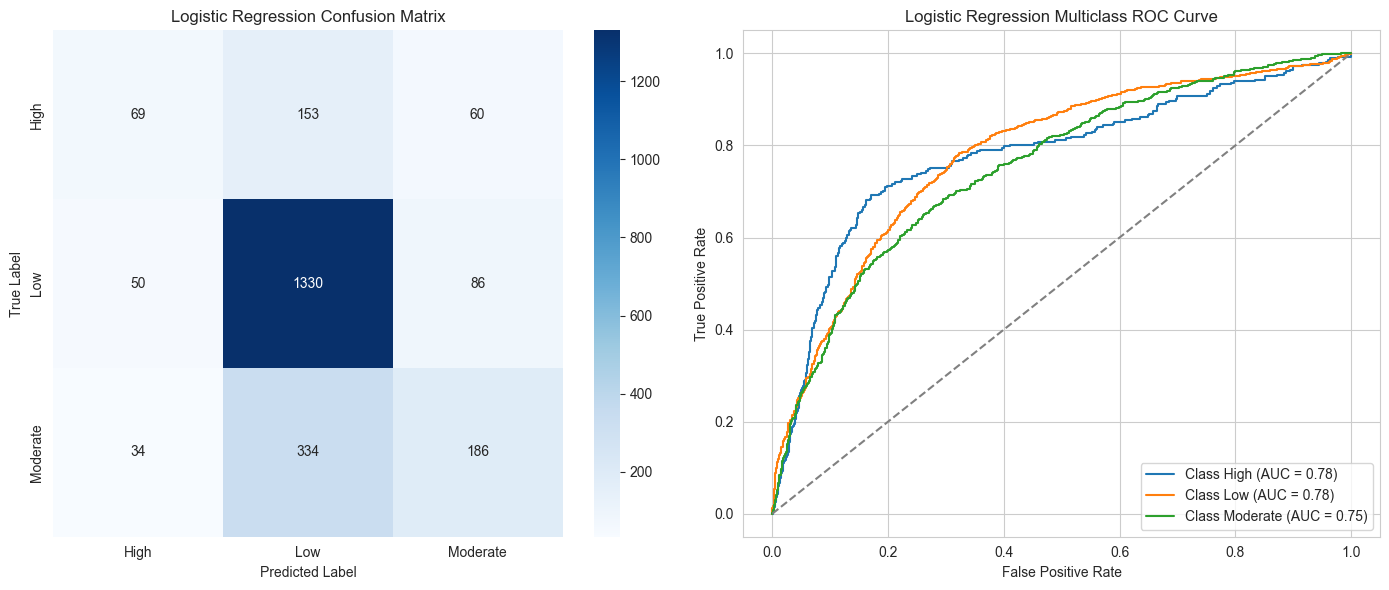

Macro-Averaged AUC Score (Logistic Regression): 0.77


In [59]:
# Generate the Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Binarize labels for Multiclass ROC Curve
y_test_bin_lr = label_binarize(y_test, classes=best_lr.classes_)
y_pred_prob_lr = best_lr.predict_proba(X_test)
n_classes_lr = y_test_bin_lr.shape[1]

# Create subplots for side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 🔹 **Confusion Matrix Plot**
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=best_lr.classes_, yticklabels=best_lr.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Logistic Regression Confusion Matrix')

# 🔹 **ROC Curve for Multiclass (One-vs-Rest)**
for i in range(n_classes_lr):
    fpr, tpr, _ = roc_curve(y_test_bin_lr[:, i], y_pred_prob_lr[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'Class {best_lr.classes_[i]} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')

# Configure ROC Curve plot
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Logistic Regression Multiclass ROC Curve')
axes[1].legend(loc='lower right')

# Display the plots
plt.tight_layout()
plt.show()

# Compute macro-averaged AUC score
macro_auc_lr = roc_auc_score(y_test_bin_lr, y_pred_prob_lr, average="macro", multi_class="ovr")
print(f"Macro-Averaged AUC Score (Logistic Regression): {macro_auc_lr:.2f}")

##### <a id='toc3_1_3_3_'></a>[**Results Interpretation**](#toc0_)

The results of the logistic regression model give us a solid starting point for predicting **the severity of anxiety attacks**. With an overall accuracy of **0.69**, the model performs fairly well, but a deeper look reveals some key weaknesses, particularly in identifying more severe cases.

* From the classification report, we see that the model is highly effective at recognizing **Low severity cases**, with a **recall of 0.91**. However, this comes at the expense of High and Moderate severity cases, which are frequently misclassified as Low. In particular, the recall for High severity is only **0.24**, meaning the model misses most of these critical cases.

* The confusion matrix confirms this pattern. While Low severity predictions are mostly accurate, the model struggles to distinguish between Moderate and High severity, often mistaking them for Low. This suggests that it may be biased toward the most common or easily recognizable patterns in the data.

* Looking at the ROC curves, we see **AUC scores around 0.75–0.78** for all classes, meaning the model does have some ability to differentiate between them, but not with great confidence.

Overall, **logistic regression provides a useful baseline**, but its tendency to under-detect High severity cases makes it clear that a more advanced model or better-balanced data would likely improve performance.

#### <a id='toc3_1_4_'></a>[**2.1.4 Feature Importance Analysis**](#toc0_)

In [60]:
# Convert target to numeric categories
y_train_cat = y_train.astype('category').cat.codes
# e.g., "Low" -> 0, "Medium" -> 1, "High" -> 2

X_train_fe = feature_engineering_lr(X_train)
X_train_fe = sm.add_constant(X_train_fe, has_constant='add')

mnlogit_model = sm.MNLogit(y_train_cat, X_train_fe)
result = mnlogit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.729108
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 9207
Model:                        MNLogit   Df Residuals:                     9163
Method:                           MLE   Df Model:                           42
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:                  0.1822
Time:                        12:03:57   Log-Likelihood:                -6712.9
converged:                       True   LL-Null:                       -8208.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              y=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 4.0122      0.268     14

In this analysis, we used Multinomial Logistic Regression to evaluate feature importance in predicting anxiety severity. While the pseudo R-squared (0.1822) suggests that the model captures some variability, our main objective was to identify which factors have the strongest influence rather than maximizing predictive performance.

The coefficients highlight key predictors: **Breathing Rate**, **Family History of Anxiety**, **Stress Level**, and **Medication show strong**, statistically significant effects, meaning they play a crucial role in distinguishing between severity levels. In contrast, features like Caffeine Intake, Alcohol Consumption, and Smoking have high p-values, indicating they have little impact and could be excluded in future models.

Although logistic regression provides a straightforward measure of importance, further exploration with Random Forest and SHAP-based methods will offer a more nuanced understanding of how each feature contributes to anxiety severity.

---

### <a id='toc3_2_'></a>[**2.2 Random Forest**](#toc0_)

#### <a id='toc3_2_1_'></a>[**2.2.1 Rationale and Preprocessing**](#toc0_)

Following the same logic as the Logistic regression, the target variable has been transformed into categories, 'other' in the Gender category have been dropped, and the features ID and Heart rate have been dropped from the predictors 


In [61]:
df_rf=df_original.copy()
df_rf=df_rf[df_rf["Gender"].str.lower() != "other"]

In [62]:
def map_severity(value):
    if 1 <= value <= 3:
        return 'Low'
    elif 4 <= value <= 6:
        return 'Moderate'
    elif 7 <= value <= 10:
        return 'High'
    
df_rf["Severity_Class"] = df_rf["Severity_of_Anxiety_Attack_(1-10)"].apply(map_severity)

df_rf.head()

ID  Age  Gender Occupation  Sleep_Hours  Physical_Activity_(hrs/week)  \
0  10440   39  Female   Engineer         10.0                           8.6   
1   3451   20    Male      Other          9.9                           6.6   
2   4592   44  Female     Doctor          5.0                           1.2   
3   7353   36    Male   Engineer          7.9                           4.4   
4    206   19    Male   Engineer          7.7                           7.5   

   Caffeine_Intake_(mg/day)  Alcohol_Consumption_(drinks/week) Smoking  \
0                        56                                  9      No   
1                       221                                 19      No   
2                       488                                 12     Yes   
3                        82                                  6      No   
4                       388                                 14     Yes   

  Family_History_of_Anxiety  Stress_Level_(1-10)  \
0                        No                    5   
1                        No                    4   
2                        No                    6   
3                       Yes                    1   
4                        No                    3   

   Heart_Rate_(bpm_during_attack)  Breathing_Rate_(breaths/min)  \
0                             104                            15   
1                              60                            29   
2                              71                            20   
3                              77                            30   
4                             178                            12   

   Sweating_Level_(1-5) Dizziness Medication  Therapy_Sessions_(per_month)  \
0                     3        No        Yes                             3   
1                     2        No        Yes                             0   
2                     2        No        Yes                             5   
3                     2       Yes        Yes                             5   
4                     2        No        Yes                             4   

  Recent_Major_Life_Event  Diet_Quality_(1-10)  \
0                      No                    9   
1                      No                    8   
2                      No                   10   
3                      No                    1   
4                     Yes                    5   

   Severity_of_Anxiety_Attack_(1-10) Severity_Class  
0                                  5       Moderate  
1                                 10           High  
2                                  5       Moderate  
3                                  3            Low  
4                                  4       Moderate

#### <a id='toc3_2_2_'></a>[**2.2.2 Model Training**](#toc0_)
In this part of the analysis, after establishing a baseline with logistic regression, we moved forward with a Random Forest classifier to capture more complex, non-linear patterns in the data that a linear model might miss. Logistic regression gave us valuable insights, particularly in terms of feature importance, but it showed clear limitations in recall for more severe cases of anxiety, which are the most critical to identify correctly. This motivated the use of a more flexible and powerful model like Random Forest, which can better handle interactions between features and doesn’t assume linearity in the data.

Since we’re working with a multiclass classification problem, one of our main concerns was class imbalance. In datasets like this, it's common for the Low severity class to dominate, which can lead the model to p achieve high overall accuracy while completely failing to identify less frequent but clinically important cases. To mitigate this, we applied SMOTE to the training set, generating synthetic examples for the minority classes. This helped the model learn more balanced decision boundaries and improved its ability to generalize across all severity levels.

Additionally, we decided to evaluate and optimize the model using weighted recall during hyperparameter tuning. Recall tells us how well the model captures true positives, and by weighting it, we ensure that each class contributes proportionally to the metric, regardless of its frequency. This is especially important in our case because misclassifying someone with High severity anxiety as Low can have serious implications. So, rather than maximizing overall accuracy, we focused on maximizing the model’s ability to correctly identify each severity class.

In [ ]:
# Feature selection
X = df_rf.drop(columns=['Severity_Class'])
y = df_rf['Severity_Class']

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define feature engineering function
def feature_engineering_rf(X):
    X = X.copy()

    # Binary columns encoding
    columns_to_transform = ["Smoking", "Family_History_of_Anxiety", "Medication", "Dizziness", "Recent_Major_Life_Event"]
    mapping = {"yes": 1, "no": 0}  # Convert the values: "yes" becomes 1 and "no" becomes 0
    for col in columns_to_transform:
        X[col] = X[col].str.lower().map(mapping)

    # Create dummies for occupation
    X = pd.get_dummies(X, columns=['Occupation'], drop_first=True)
    occupation_dummy_cols = [col for col in X.columns if 'Occupation_' in col]
    X[occupation_dummy_cols] = X[occupation_dummy_cols].astype(int)

    # Gender encoding: 1 for Female, 0 for others
    X['Gender'] = X['Gender'].apply(lambda x: 1 if x.lower() == 'female' else 0)

    # Drop unnecessary columns
    return X.drop(columns=['ID', 'Heart_Rate_(bpm_during_attack)','Severity_of_Anxiety_Attack_(1-10)'], errors='ignore')

# Define FunctionTransformer for feature engineering
feature_transformer_rf = FunctionTransformer(feature_engineering_rf, validate=False)

# Apply feature engineering
X_train_transformed = feature_engineering_rf(X_train)
X_test_transformed = feature_engineering_rf(X_test)

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Define pipeline
rf_pipeline = Pipeline([
    ('feature_engineering', feature_transformer_rf),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV on the resampled training set
grid_search_rf = GridSearchCV(
    rf_pipeline.named_steps['classifier'],
    param_grid,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Get predictions on test data
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test_transformed)

# Compute metrics
rf_best_acc = accuracy_score(y_test, y_pred_rf_best)
rf_best_report = classification_report(y_test, y_pred_rf_best)

c:\Users\mtdaf\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mtdaf\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\mtdaf\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mtdaf\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\mtdaf\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(exe

Fitting 5 folds for each of 16 candidates, totalling 80 fits


#### <a id='toc3_2_3_'></a>[**2.2.3 Evaluation**](#toc0_)

##### <a id='toc3_2_3_1_'></a>[**Classification Report**](#toc0_)

In [64]:
print("Best Parameters Found:", grid_search_rf.best_params_)
print("Random Forest Accuracy:", rf_best_acc)
print("Classification Report:\n", rf_best_report)

Best Parameters Found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy: 0.6642050390964379
Classification Report:
               precision    recall  f1-score   support

        High       0.36      0.61      0.46       282
         Low       0.83      0.76      0.79      1458
    Moderate       0.51      0.45      0.47       562

    accuracy                           0.66      2302
   macro avg       0.57      0.60      0.57      2302
weighted avg       0.69      0.66      0.67      2302



##### <a id='toc3_2_3_2_'></a>[**Confusion Matrix and ROC Curve**](#toc0_)

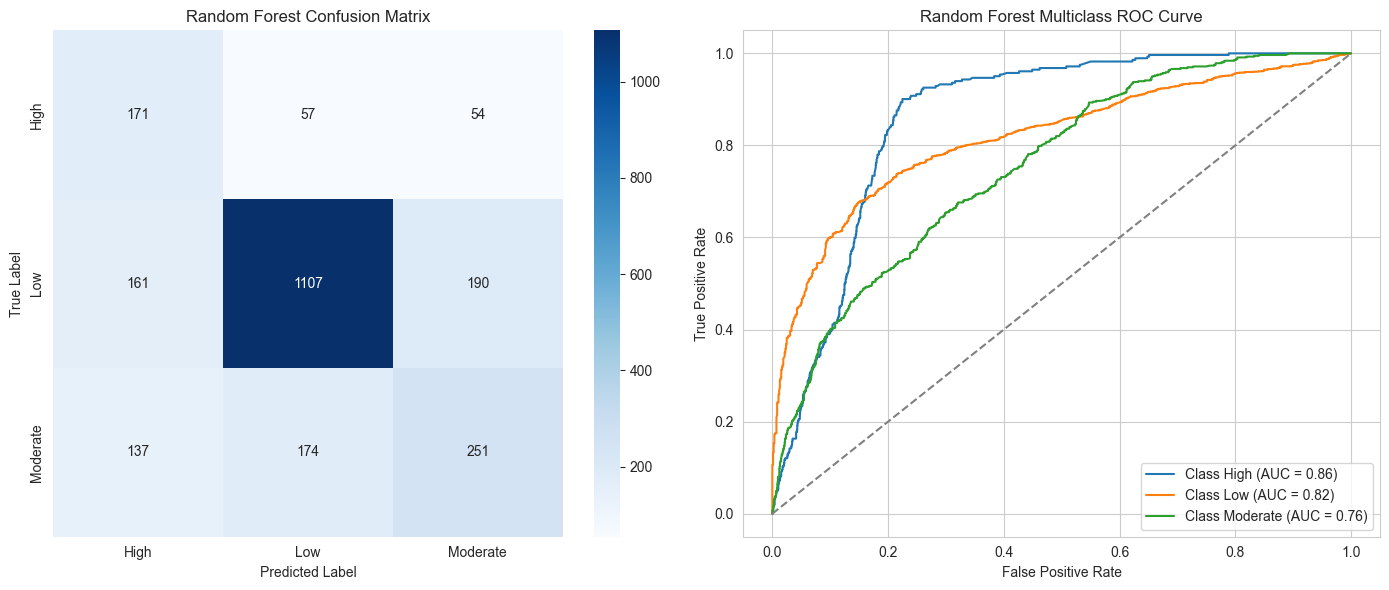

Macro-Averaged AUC Score (Random Forest): 0.81


In [65]:
# Generate the Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_best)

# Binarize labels for Multiclass ROC Curve
y_test_bin_rf = label_binarize(y_test, classes=best_rf_model.classes_)
y_pred_prob_rf = best_rf_model.predict_proba(X_test_transformed)
n_classes_rf = y_test_bin_rf.shape[1]

# Create subplots for side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 🔹 **Confusion Matrix Plot**
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Random Forest Confusion Matrix')

# 🔹 **ROC Curve for Multiclass (One-vs-Rest)**
for i in range(n_classes_rf):
    fpr, tpr, _ = roc_curve(y_test_bin_rf[:, i], y_pred_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'Class {best_rf_model.classes_[i]} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')

# Configure ROC Curve plot
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Random Forest Multiclass ROC Curve')
axes[1].legend(loc='lower right')

# Display the plots
plt.tight_layout()
plt.show()

# Compute macro-averaged AUC score
macro_auc_rf = roc_auc_score(y_test_bin_rf, y_pred_prob_rf, average="macro", multi_class="ovr")
print(f"Macro-Averaged AUC Score (Random Forest): {macro_auc_rf:.2f}")

##### <a id='toc3_2_3_3_'></a>[**Results Interpretation**](#toc0_)
The Random Forest model improves significantly in identifying High severity cases, with a 65% recall, though it still struggles with Moderate severity (44% recall), often misclassifying it as Low. Low severity cases remain the easiest to detect, with a 76% recall and 82% precision. However, High severity precision is just 37%, meaning many predicted High cases are actually Moderate or Low.

The confusion matrix confirms this, showing frequent misclassifications between adjacent severity levels, likely due to overlapping symptoms. The ROC curve and AUC scores reinforce this pattern: High severity has an AUC of 0.87, making it the most distinguishable class, while Moderate remains the hardest to classify (AUC 0.76).

Overall, Random Forest gave us a more flexible and recall-oriented model, but its limitations, particularly in handling the Moderate class, motivated us to explore a more powerful alternative in XGBoost.

#### <a id='toc3_2_4_'></a>[**2.2.4 Feature Importance Analysis and Model Explainability with SHAP**](#toc0_)

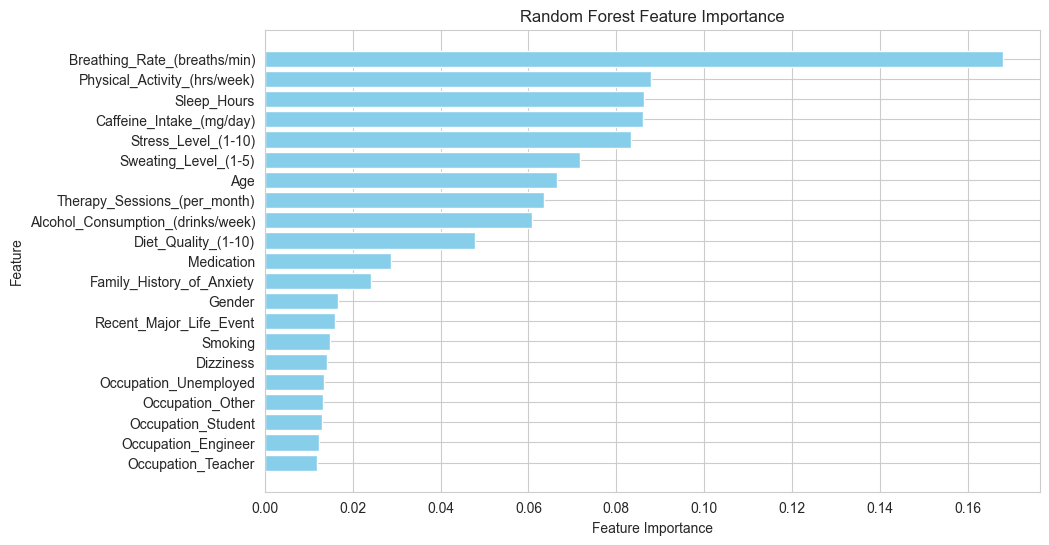

In [66]:
# Create a DataFrame with feature importances (if not already created)
importance_df = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

c:\Users\mtdaf\myenv\Lib\site-packages\shap\explainers\_tree.py:217: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


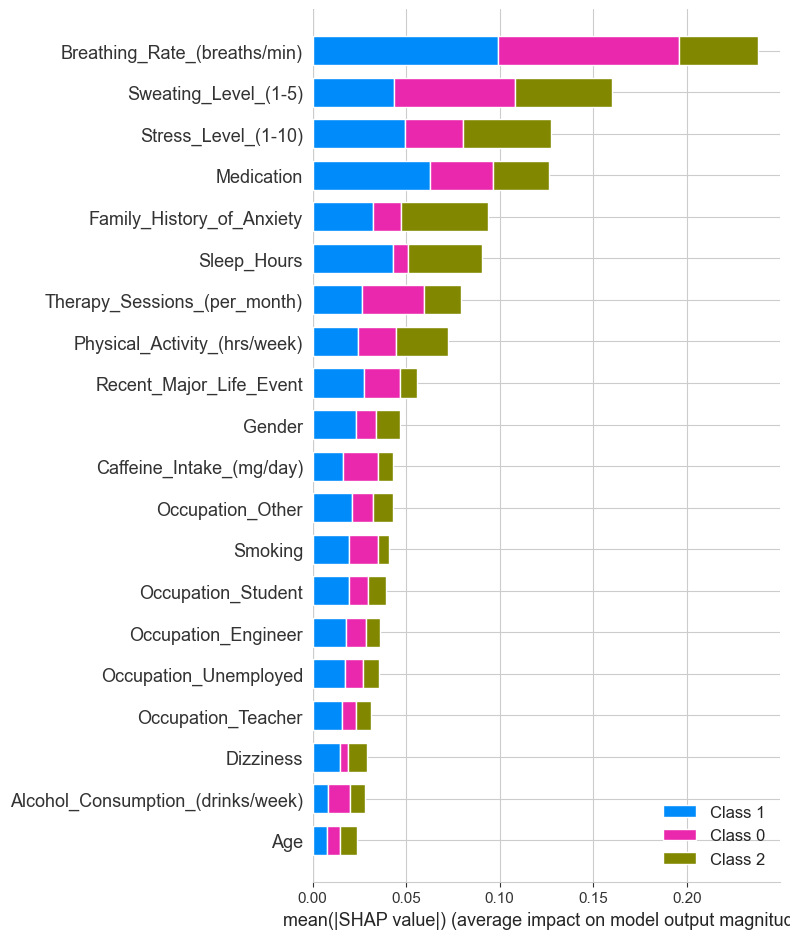

<Figure size 640x480 with 0 Axes>

In [67]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf_model, feature_perturbation="interventional")

# Compute SHAP values
shap_values = explainer(X_test_transformed)

# Create figure and adjust size before plotting
fig, ax = plt.subplots(figsize=(12, 6)) 
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", show=True)

plt.tight_layout()
plt.show()

* The Random Forest and SHAP results give a clear picture of which factors influence anxiety severity predictions. Breathing Rate is the most critical feature, strongly linked to higher severity, followed by Physical Activity, Caffeine Intake, Sleep Hours, and Stress Level, reinforcing the role of lifestyle in anxiety.

* SHAP values add more interpretability, showing how features impact different severity classes rather than just ranking them. Sweating Level and Medication are particularly relevant across all classes, while Occupation type, Smoking, and Alcohol Consumption appear less significant.

* Overall, biological and behavioral indicators dominate over demographic factors, with Random Forest and SHAP largely aligning on key predictors.

---

### <a id='toc3_3_'></a>[**2.3 XGBoost**](#toc0_)

In [68]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

#### <a id='toc3_3_1_'></a>[**2.3.1 Data Preprocessing - Rationale**](#toc0_)

Following a similar logic as the prvious models, the continuous anxiety severity score (1–10) was grouped into three categories: Low, Moderate, and High. This simplifies the task into a multi-class classification problem, making the predictions more actionable for business use. These categories were then numerically encoded to allow model processing. The original severity score and the heart rate during an attack were removed from the dataset. While the former was replaced by the categorized target, the latter was excluded because it reflects a physiological response measured during an anxiety attack. Since this information is not available beforehand, it would not be useful for predicting future attacks and could lead to misleading results if included. The final feature set also excluded irrelevant identifiers, and the dataset was split into training and test sets to ensure fair model evaluation.

In [69]:
# Prepare dataset
df_xgb = df_original.copy()

# Transform occupation column to one-hot encoded columns
df_xgb = pd.get_dummies(df_xgb, columns=["Occupation"], drop_first=True)

# Drop others
df_xgb = df_xgb[df_xgb["Gender"] != "Other"]

# Encoding for Binary columns
df_xgb = df_xgb.replace({'Yes': 1, 'No': 0})
df_xgb = df_xgb.replace({'True': 1, 'False': 0})
df_xgb = df_xgb.replace({'Female': 0, 'Male': 1})

C:\Users\mtdaf\AppData\Local\Temp\ipykernel_26772\4089836984.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_xgb = df_xgb.replace({'Yes': 1, 'No': 0})
C:\Users\mtdaf\AppData\Local\Temp\ipykernel_26772\4089836984.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_xgb = df_xgb.replace({'Female': 0, 'Male': 1})


In [70]:
# Transform all columns to float
df_xgb = df_xgb.astype(float)

*Targte Variable Tranformation*

In [71]:
### Prepare target variable
# Map Severity into categories
def map_severity(value):
    if 1 <= value <= 3:
        return 'Low'
    elif 4 <= value <= 6:
        return 'Moderate'
    elif 7 <= value <= 10:
        return 'High'
    
df_xgb['Severity_Class'] = df_xgb['Severity_of_Anxiety_Attack_(1-10)'].apply(map_severity)
 
# Define a custom mapping for the labels
custom_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
 
# Encode the classes
df_xgb['Severity_Class_Encoded'] = df_xgb["Severity_Class"].map(custom_mapping)
 
# Drop the original severity column
df_xgb = df_xgb.drop(columns=['Severity_of_Anxiety_Attack_(1-10)', 'Heart_Rate_(bpm_during_attack)'])
 
# Separate features and target
X = df_xgb.drop(columns=['Severity_Class', 'Severity_Class_Encoded', 'ID'])
y = df_xgb['Severity_Class_Encoded']
 
# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### <a id='toc3_3_2_'></a>[**2.3.2 Model Training**](#toc0_)
* The model training process begins with fitting an initial XGBoost classifier, using multi-class log loss as the evaluation metric. XGBoost was chosen for its high performance with structured data, ability to handle imbalanced classes, and built-in feature selection. Its gradient boosting framework makes it particularly effective for capturing complex relationships in healthcare data while maintaining computational efficiency.

* Feature importance is then analyzed, and low-importance features are removed based on a predefined threshold (0.03) to improve model interpretability and efficiency.

* Next, grid search with cross-validation is performed to optimize hyperparameters, testing multiple combinations of tree depth, learning rate, and sampling strategies. The best-performing model is selected based on weighted recall, ensuring a balance between generalization and predictive power. The final step involves evaluating the model on the test set, generating performance metrics such as precision, recall, and F1-score, and saving the trained model for future predictions.

In [72]:
# Train the initial XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42)
model.fit(X_train, y_train)

# Perform threshold-based feature selection
feature_importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Define a threshold for feature importance
threshold = 0.03
selected_features = importance_df[importance_df['Importance'] >= threshold]['Feature']

# Reduce dataset
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Step 6: Perform grid search with cross-validation
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='recall_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

# Step 7: Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Step 8: Evaluate the best model
y_pred = best_model.predict(X_test_reduced)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


#### <a id='toc3_3_3_'></a>[**2.3.3 Evaluation**](#toc0_)

##### <a id='toc3_3_3_1_'></a>[**Classification Report**](#toc0_)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1466
           1       0.58      0.40      0.47       554
           2       0.42      0.46      0.44       282

    accuracy                           0.70      2302
   macro avg       0.60      0.57      0.58      2302
weighted avg       0.69      0.70      0.69      2302



##### <a id='toc3_3_3_2_'></a>[**Confusion Matrix and ROC Curve**](#toc0_)

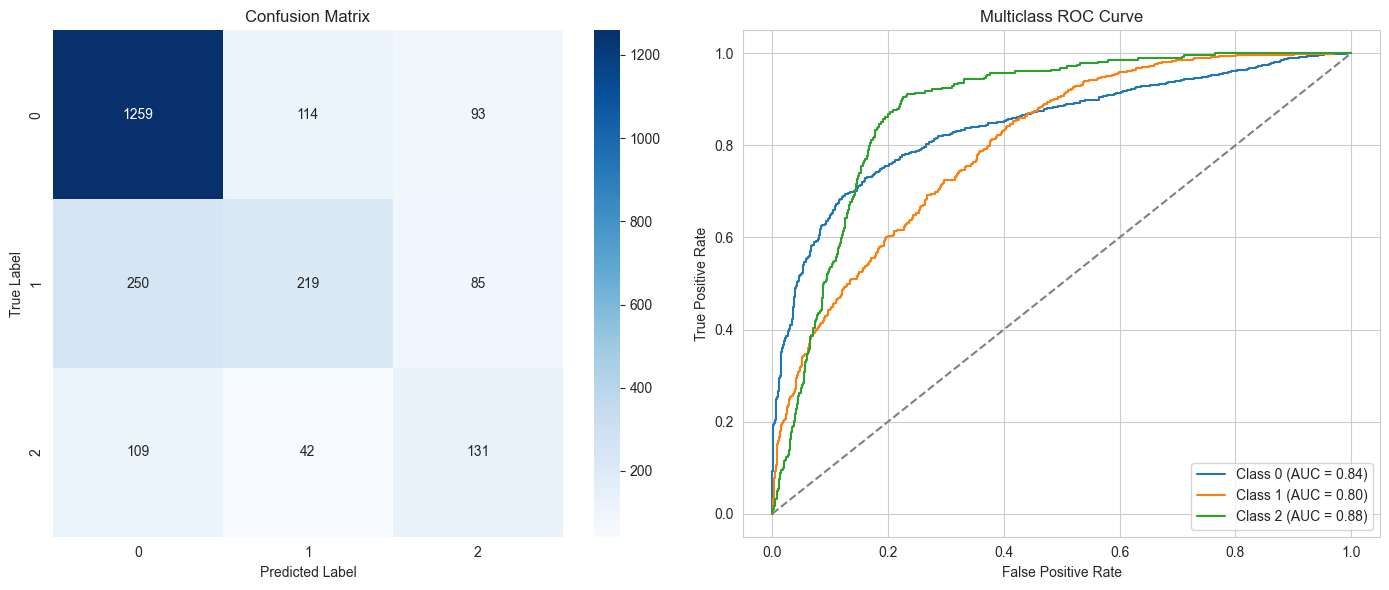

Macro-Averaged AUC Score: 0.84


In [74]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Binarize the labels for multiclass ROC curve
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_prob = best_model.predict_proba(X_test_reduced)
n_classes = y_test_bin.shape[1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

# Plot ROC Curve for Multiclass
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'Class {best_model.classes_[i]} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')

# Configure ROC Curve plot
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC Curve')
axes[1].legend(loc='lower right')

# Show the plots
plt.tight_layout()
plt.show()

# Compute macro-averaged AUC score
macro_auc = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")
print(f"Macro-Averaged AUC Score: {macro_auc:.2f}")

##### <a id='toc3_3_3_3_'></a>[**Results Interpretation**](#toc0_)

Overall, the optimized model provides reasonable accuracy but performs best with low-anxiety cases, while struggling to accurately classify moderate and high-anxiety levels.

* Overall Accuracy: 70%, acceptable for multi-class classification but with potential for improvement.
* Low Anxiety Class (Class 0): High precision (0.78) and recall (0.86), showing strong identification of low anxiety cases.
* Moderate Anxiety Class (Class 1): Lower precision (0.58) and recall (0.41), indicating difficulty distinguishing moderate anxiety from other classes.
* High Anxiety Class (Class 2): Weak performance (0.40 recall), highlighting challenges in accurately identifying severe anxiety cases.
* Confusion Matrix Insight: Model tends to overpredict low anxiety, struggling to clearly separate moderate and high anxiety cases.

#### <a id='toc3_3_4_'></a>[**2.3.4 Feature Importance Analysis**](#toc0_)
The feature importance analysis identifies the most influential variables in predicting anxiety attack severity. The XGBoost model assigns an importance score to each feature based on its contribution to model decisions. The plot highlights the top 10 features, ranked by their impact.

<Figure size 1000x800 with 0 Axes>

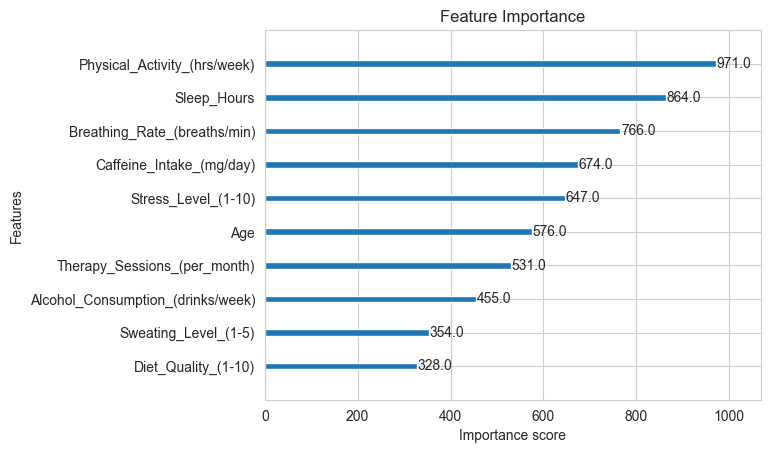

In [75]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

**Key Findings**
* Sleep hours is the most critical factor, indicating that sleep patterns strongly influence anxiety severity.

* Physical activity and caffeine intake follow closely, suggesting that lifestyle habits play a major role in mental health outcomes.

* Age also holds significant predictive power, likely due to variations in anxiety prevalence across different age groups.

* Physiological indicators like breathing rate and sweating level are important but ranked lower, showing that behavioral factors might have a stronger predictive signal than immediate physical responses.

#### <a id='toc3_3_5_'></a>[**2.3.5 Model Explainability - SHAP Values**](#toc0_)

 99%|===================| 6855/6906 [01:43<00:00]        

SHAP Summary Plot


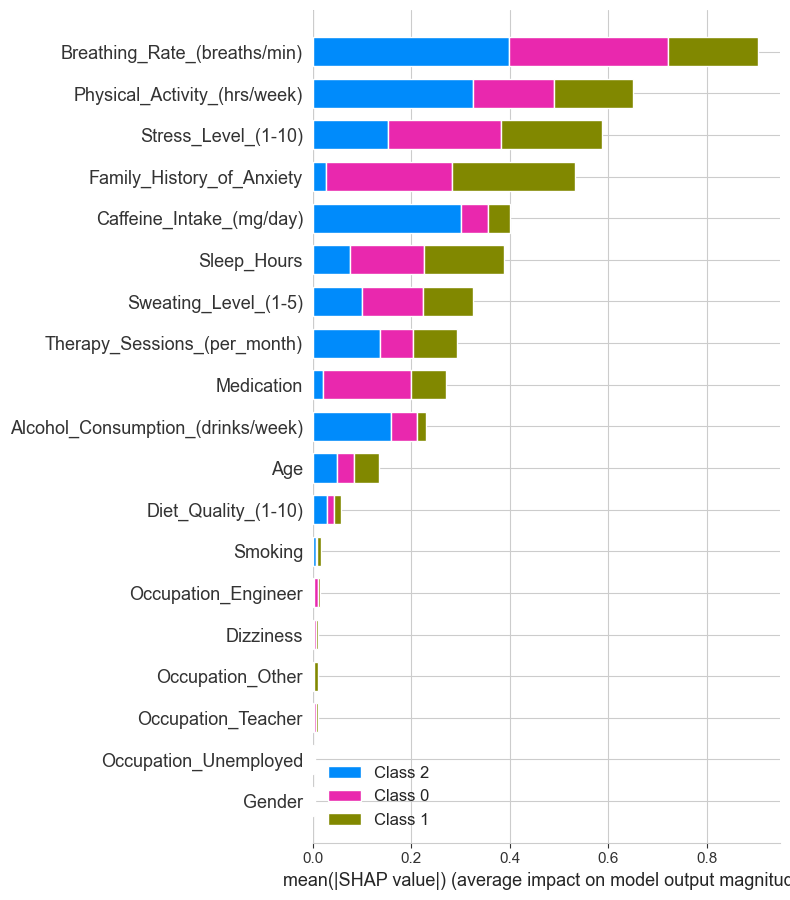

In [76]:
# Initialize the SHAP explainer
explainer = shap.Explainer(best_model, X_train_reduced)
 
# Calculate SHAP values for the test set
shap_values = explainer(X_test_reduced)  # Returns a SHAP values object
 
# Plot the summary plot
print("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test_reduced, plot_type="bar")  # Bar plot for feature importance
# shap.summary_plot(shap_values, X_test_reduced)  # Detailed summary plot

**Interpretation**
* Breathing rate and stress level are the strongest predictors of anxiety attack severity, confirming that physiological and psychological factors play a crucial role in determining risk levels.

* Family history of anxiety significantly impacts predictions, suggesting a strong genetic or environmental component that insurers may consider for early interventions.

* Physical activity and sleep hours remain highly influential, reinforcing the importance of lifestyle factors in mental health management.

* Sweating level, therapy sessions, and caffeine intake also contribute, but to a lesser extent, indicating secondary influences on anxiety severity.

* Occupation and demographic features (e.g., gender, smoking, specific job roles) have minimal impact, meaning they do not meaningfully differentiate risk levels in this model.

These findings validate the need for targeted interventions based on lifestyle and physiological factors rather than broad demographic assumptions. Insurers can leverage these insights to develop personalized mental health support plans, focusing on clients with high-risk indicators like stress, irregular breathing patterns, and genetic predisposition.

 99%|===================| 6822/6906 [01:08<00:00]        

SHAP Summary Plot for Class 0


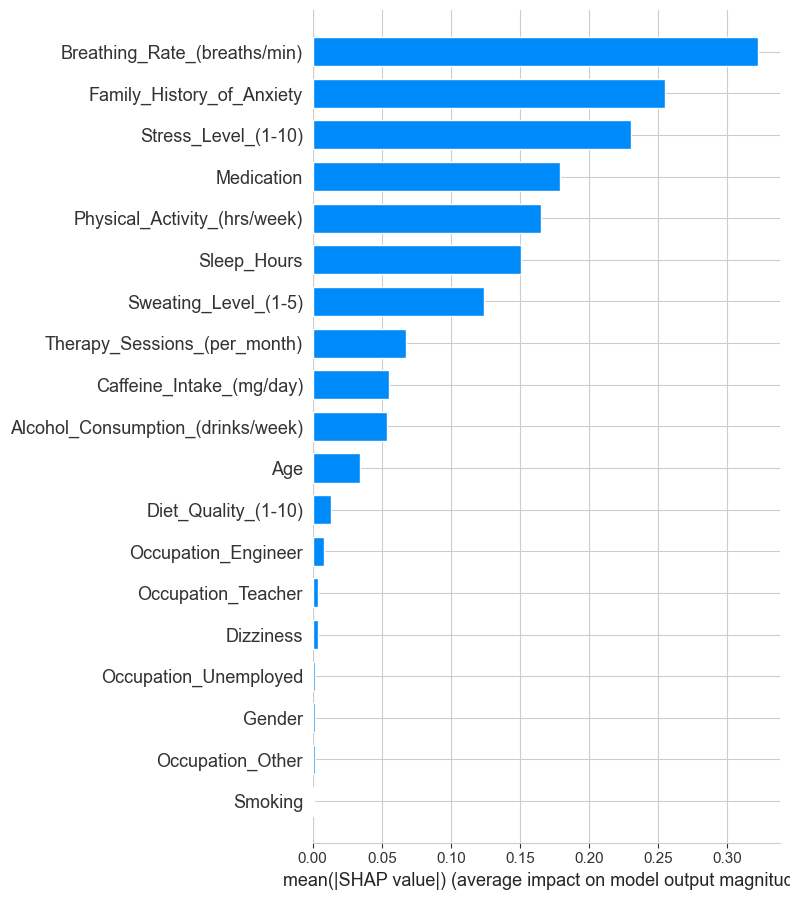

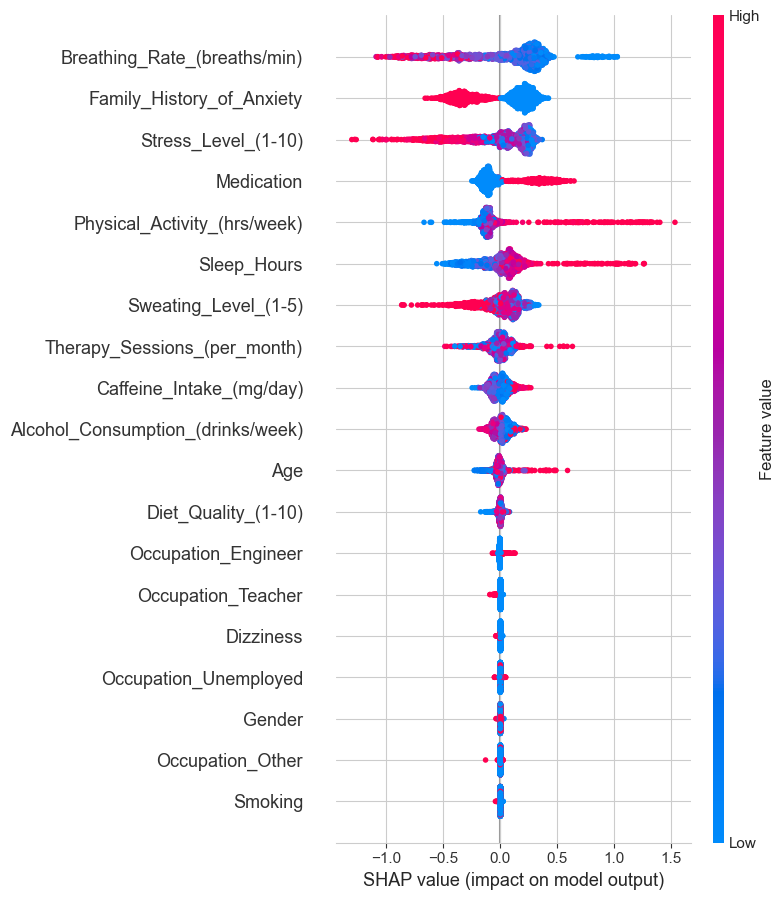

SHAP Summary Plot for Class 1


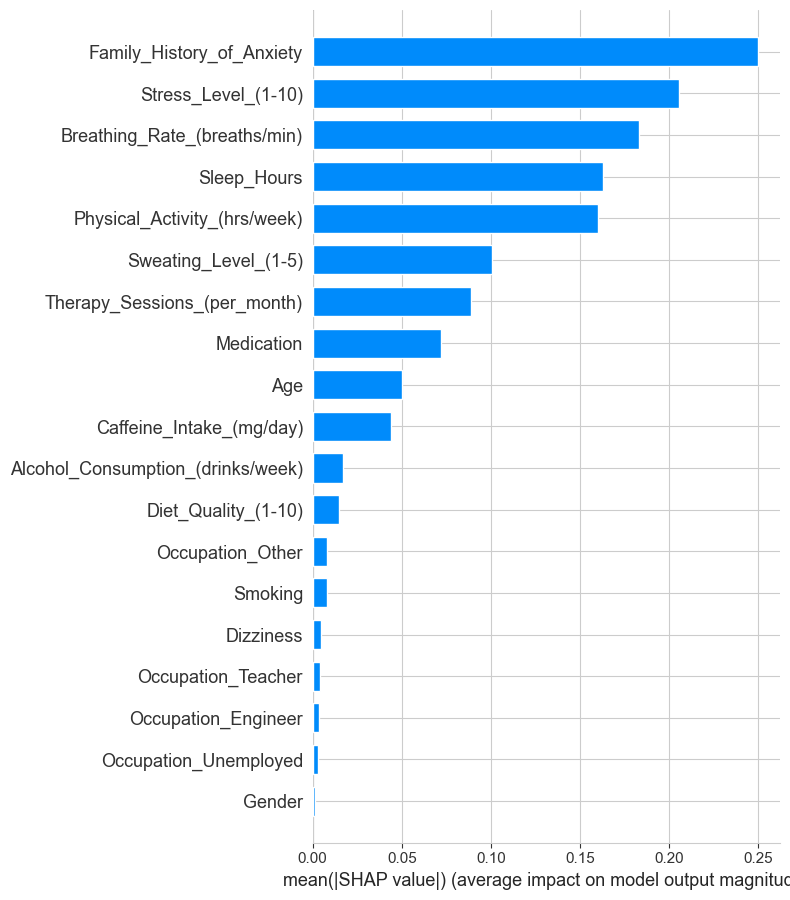

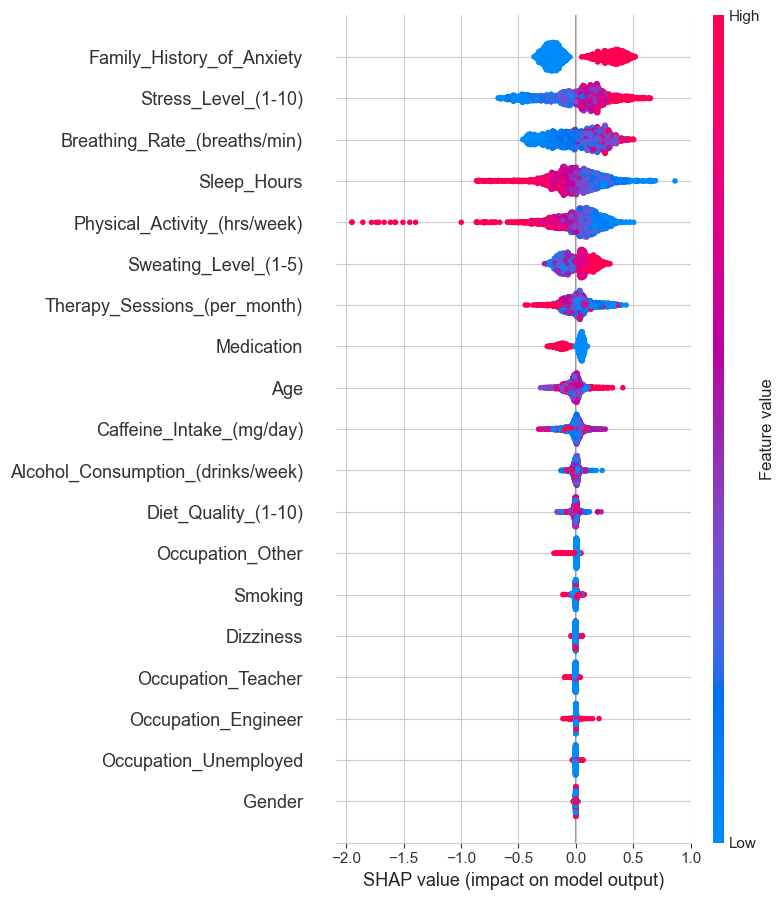

SHAP Summary Plot for Class 2


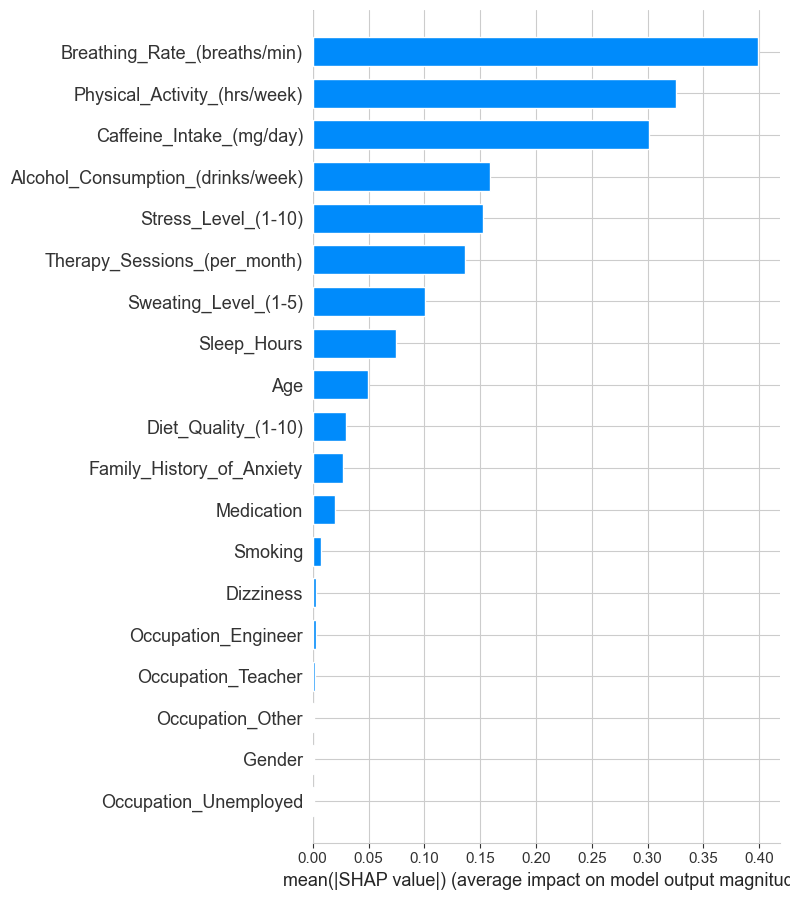

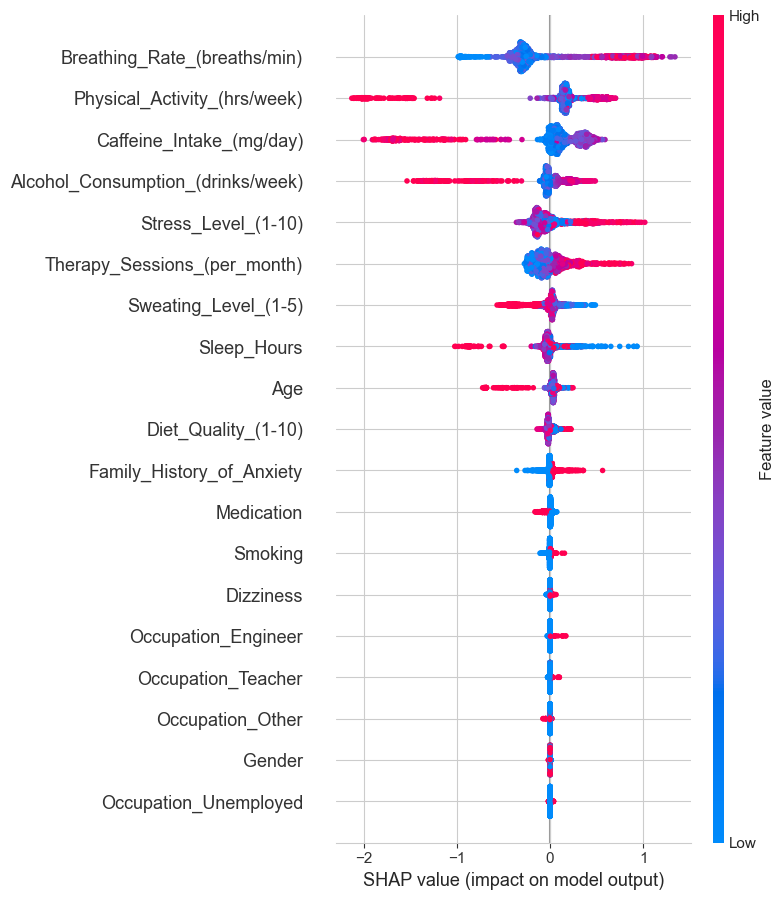

In [77]:
# Initialize the SHAP explainer with the training data as the background dataset
explainer = shap.Explainer(best_model, X_train_reduced)
 
# Calculate SHAP values for the test set
shap_values = explainer(X_test_reduced)  # Returns a SHAP values object
 
# Iterate over each class and plot SHAP summary plots
for class_index in range(len(explainer.expected_value)):
    print(f"SHAP Summary Plot for Class {class_index}")
    shap.summary_plot(shap_values[..., class_index], X_test_reduced, plot_type="bar")  # Bar plot for feature importance
    shap.summary_plot(shap_values[..., class_index], X_test_reduced)  # Detailed summary plot

**SHAP-Key Findings:**

* **High Anxiety Severity (Class 2):** Predominantly influenced by strong physiological indicators, such as significant irregularities in breathing patterns and elevated stress levels, which reflect intense emotional and physical symptoms. Excessive caffeine consumption notably intensifies anxiety episodes, while lifestyle factors like physical activity and alcohol intake play a secondary yet meaningful role. Genetic predisposition and demographic characteristics (gender, occupation, and age) have minimal predictive power, suggesting severe anxiety is largely driven by immediate physiological and stress-related triggers.

* **Moderate Anxiety Severity (Class 1):** Primarily characterized by genetic predisposition, with family history emerging as the strongest predictor, indicating that moderate anxiety is more common among those genetically vulnerable. Stress levels and breathing rate also significantly influence classification, underscoring the combined role of psychological and physiological responses. Lifestyle factors such as sleep quality and physical activity are relevant but not definitive, whereas demographic attributes and substance consumption (caffeine and alcohol) show relatively minor impacts.

* **Low Anxiety Severity (Class 0):** Strongly associated with stable physiological states, particularly regular breathing patterns and lower stress levels, supported by sufficient sleep and effective medication use. Genetic factors, such as family history, influence classification but are effectively mitigated by healthy lifestyle practices, including regular physical activity. While demographic features and caffeine/alcohol intake still matter, their influence is limited compared to the primary physiological, psychological, and lifestyle-related factors that help maintain low anxiety severity.

## <a id='toc4_'></a>[**3. Save best model as Pickle file**](#toc0_)

---

In [78]:
# Define the filename in the required format
filename = "Group_W_Model.pkl" 

# Save the best Random Forest pipeline as a Pickle file
with open(filename, 'wb') as file:
    pickle.dump(best_rf_model, file)

print(f"Model saved successfully as {filename}")

Model saved successfully as Group_W_Model.pkl


In [79]:
pip freeze > Group_W_requirements.txt

Note: you may need to restart the kernel to use updated packages.
